In [2]:
from model import *
from data import *
from helpers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import DataLoader, Dataset
import sys
import time
import os
import random
import torch

# set device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load configurations
with open("./config.yml", "r") as f:
    cfg = yaml.safe_load(f)
    cfg = cfg['configs']

    


In [8]:
# simulate data
if cfg['simulate']:
    random.seed(1)
    theta=np.random.normal(0,1,cfg['N']*cfg['mirt_dim']).reshape((cfg['N'], cfg['mirt_dim']))
    Q = pd.read_csv(f'parameters/QMatrix{cfg["mirt_dim"]}D.csv', header=None, dtype=float).values

    a = np.random.uniform(.5, 2, Q.shape[0] * cfg['mirt_dim']).reshape((Q.shape[0], cfg['mirt_dim']))  # draw discrimination parameters from uniform distribution
    a *= Q
    b = np.linspace(-2, 2, Q.shape[0], endpoint=True)  # eqally spaced values between -2 and 2 for the difficulty
    exponent = np.dot(theta, a.T) + b

    prob = np.exp(exponent) / (1 + np.exp(exponent))
    data = np.random.binomial(1, prob).astype(float)
else:
    data = pd.read_csv(f'./data/simulated/data_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', header=None, index_col=False).to_numpy()
    a = pd.read_csv(f'./parameters/simulated/a_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', header=None, index_col=False).to_numpy()
    b = pd.read_csv(f'./parameters/simulated/b_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', header=None, index_col=False).to_numpy()
    theta = pd.read_csv(f'./parameters/simulated/theta_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', header=None, index_col=False).to_numpy()
    Q = pd.read_csv(f'./parameters/QMatrix{cfg["mirt_dim"]}D.csv', header=None).values

# potentially save data to disk
if cfg['save']:
    np.savetxt(f'./data/simulated/data_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', data, delimiter=",")
    np.savetxt(f'./parameters/simulated/a_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', a, delimiter=",")
    np.savetxt(f'./parameters/simulated/b_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', b, delimiter=",")
    np.savetxt(f'./parameters/simulated/theta_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', theta, delimiter=",")

# introduce missingness
np.random.seed(cfg['iteration'])
indices = np.random.choice(data.shape[0]*data.shape[1], replace=False, size=int(data.shape[0]*data.shape[1]*cfg['missing_percentage']))
data[np.unravel_index(indices, data.shape)] = float('nan')
data = torch.Tensor(data)

# X = pd.read_csv('./data/missing/data.csv', index_col=0).to_numpy()
# a = pd.read_csv('./data/missing/a.csv', index_col=0).to_numpy()
# theta = pd.read_csv('./data/missing/theta.csv', index_col=0).to_numpy()
# d = pd.read_csv('./data/missing/d.csv', index_col=0).to_numpy()
# Q = (a != 0).astype(int)


# initialise model and optimizer
logger = CSVLogger("logs", name='simfit', version=0)
trainer = Trainer(fast_dev_run=cfg['single_epoch_test_run'],
                  max_epochs=cfg['max_epochs'],
                  enable_checkpointing=False, 
                  logger=False, 
                  callbacks=[EarlyStopping(monitor='train_loss', min_delta=cfg['min_delta'], patience=cfg['patience'], mode='min')])

if cfg['model'] == 'cvae':
    dataset = SimDataset(data)
    train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
    vae = CVAE(nitems=data.shape[1],
               dataloader=train_loader,
               latent_dims=cfg['mirt_dim'],
               hidden_layer_size=cfg['hidden_layer_size'],
               hidden_layer_size2=cfg['hidden_layer_size2'],
               hidden_layer_size3=cfg['hidden_layer_size3'],
               qm=Q,
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0]

    )
elif cfg['model'] == 'idvae':
    dataset = SimDataset(data)
    train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
    vae = IDVAE(nitems=data.shape[1],
               dataloader=train_loader,
               latent_dims=cfg['mirt_dim'],
               hidden_layer_size=cfg['hidden_layer_size2'],
               hidden_layer_size2=cfg['hidden_layer_size3'],
               qm=Q,
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0]

    )
elif cfg['model'] == 'ivae':
    vae = IVAE(nitems=data.shape[1],
               data=data,
               latent_dims=cfg['mirt_dim'],
               hidden_layer_size=cfg['hidden_layer_size2'],
               hidden_layer_size2=cfg['hidden_layer_size3'],
               qm=Q,
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0],#cfg['batch_size']
               i_miss=indices,
    )
elif cfg['model'] == 'pvae':
    dataset = PartialDataset(data)
    train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
    vae = PVAE(dataloader=train_loader,
               nitems=Q.shape[0],
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0],
               emb_dim=cfg['p_emb_dim'],
               h_hidden_dim=cfg['p_hidden_dim'],
               latent_dim=cfg['p_latent_dim'],
               hidden_layer_dim=cfg['p_hidden_layer_dim'],
               mirt_dim=cfg['mirt_dim'],
               Q=Q,
               beta=1
    )
elif cfg['model'] == 'iwae':
    dataset = SimDataset(data)
    train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
    vae = IWAE(nitems=data.shape[1],
               dataloader=train_loader,
               latent_dims=cfg['mirt_dim'],
               hidden_layer_size=cfg['hidden_layer_size'],
               hidden_layer_size2=cfg['hidden_layer_size2'],
               hidden_layer_size3=cfg['hidden_layer_size3'],
               qm=Q,
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0],
               n_samples=cfg['n_iw_samples']
    )
elif cfg['model'] == 'vae':
    dataset = SimDataset(data)
    train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
    vae = VAE(nitems=data.shape[1],
               dataloader=train_loader,
               latent_dims=cfg['mirt_dim'],
               hidden_layer_size=cfg['hidden_layer_size2'],
               hidden_layer_size2=cfg['hidden_layer_size3'],
               qm=Q,
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0]

    )
else:
    raise Exception("Invalid model type")



GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/karel/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/karel/Documents/GitHub/MIRT-VAE-QMAtrix/data.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_train = torch.tensor(X, dtype=torch.float32)


In [9]:
start = time.time()
trainer.fit(vae)
runtime = time.time()-start
print(runtime)

a_est = vae.decoder.weights.t().detach().numpy()
d_est = vae.decoder.bias.t().detach().numpy()
vae = vae.to(device)

if cfg['model'] in ['cvae', 'iwae']:
    dataset = SimDataset(data, device)
    train_loader = DataLoader(dataset, batch_size=data.shape[0], shuffle=False)
    data, mask = next(iter(train_loader))
    theta_est, _ = vae.encoder(data, mask)
elif cfg['model'] in ['idvae', 'vae']:
    dataset = SimDataset(data, device)
    train_loader = DataLoader(dataset, batch_size=data.shape[0], shuffle=False)
    data, mask = next(iter(train_loader))
    theta_est, _ = vae.encoder(data)
elif cfg['model'] == 'ivae':
    theta_est, _ = vae.encoder(vae.data)
elif cfg['model'] == 'pvae':
    dataset = PartialDataset(data, device)
    train_loader = DataLoader(dataset, batch_size=data.shape[0], shuffle=False)
    item_ids, ratings, _, _ = next(iter(train_loader))
    theta_est, _ = vae.encoder(item_ids, ratings)


theta_est = theta_est.detach().cpu().numpy()
if cfg['mirt_dim'] == 1:
    theta = np.expand_dims(theta, 1)
# invert factors for increased interpretability
a_est, theta_est = inv_factors(a_est=a_est, theta_est=theta_est, a_true=a)

mse_a = f'{MSE(a_est, a)}\n'
mse_d = f'{MSE(d_est, b)}\n'
mse_theta = f'{MSE(theta_est, theta)}\n'

lll = f'{loglikelihood(a_est, d_est, theta_est, data.numpy())}\n'

# print results
print(mse_a)
print(mse_d)
print(mse_theta)


  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder       | 856   
1 | sampler | SamplingLayer | 0     
2 | decoder | Decoder       | 112   
------------------------------------------
968       Trainable params
0         Non-trainable params
968       Total params
0.004     Total estimated model params size (MB)
/Users/karel/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

34.103549003601074
0.9922775512397469
0.9961017140597167
-0.9860723287512257
flipping dimension 2
0.015685635049568904

0.017660809867501914

0.31067856358639945



Text(0, 0.5, 'Estimates')

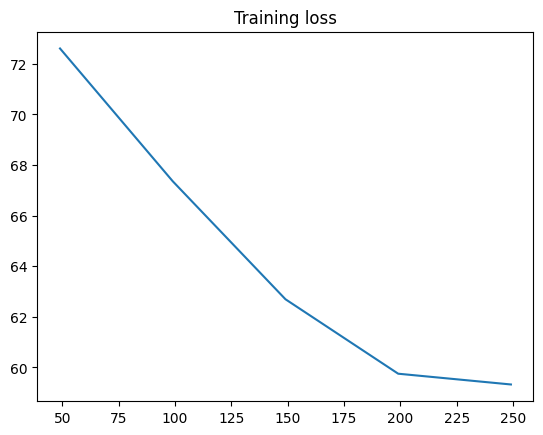

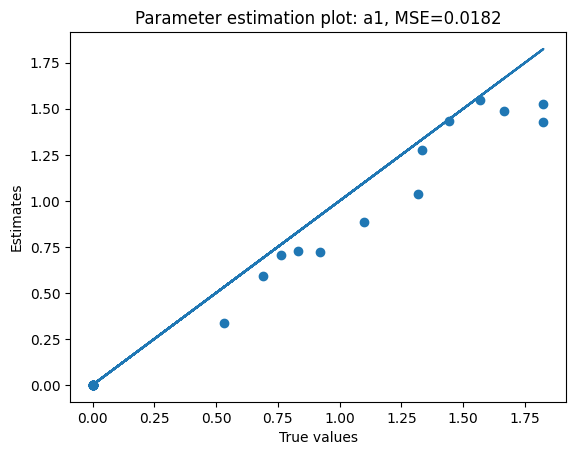

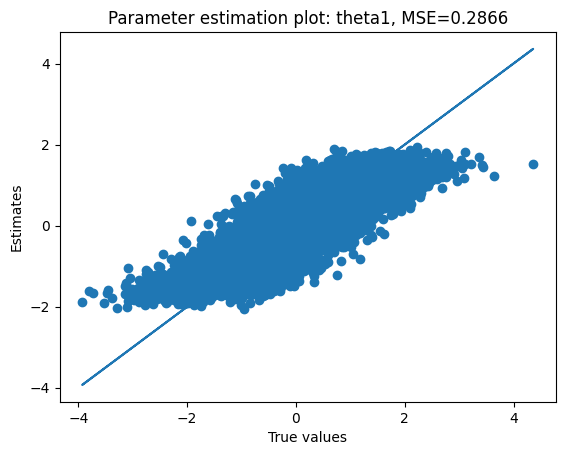

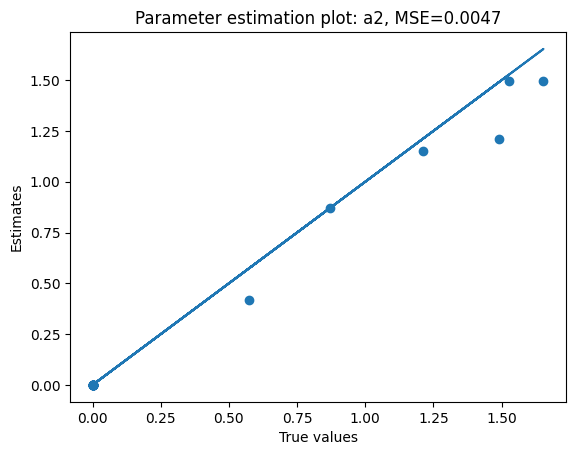

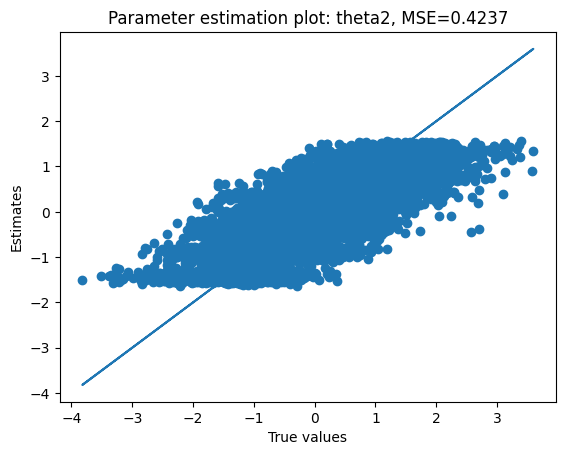

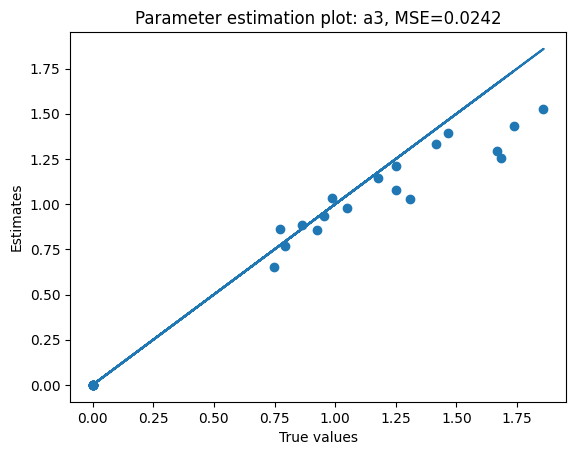

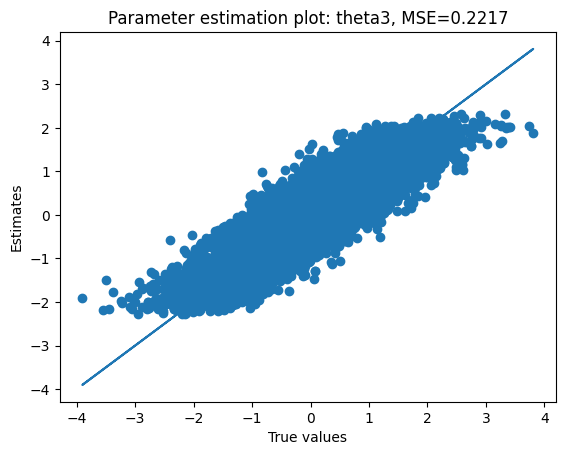

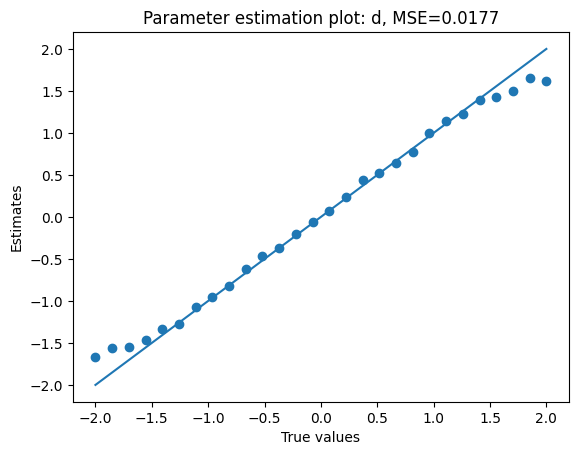

In [10]:


# plot training loss
logs = pd.read_csv(f'logs/simfit/version_0/metrics.csv')
plt.plot(logs['epoch'], logs['train_loss'])
plt.title('Training loss')
plt.savefig(f'./figures/simfit/training_loss.png')


# plot binary cross entropy
# plt.clf()
# plt.plot(logs['epoch'], logs['binary_cross_entropy'])
# plt.title('Binary Cross Entropy')
# plt.savefig(f'./figures/simfit/binary_cross_entropy.png')
# # plot KL divergence
# plt.clf()
# plt.plot(logs['epoch'], logs['kl_divergence'])
# plt.title('KL Divergence')
# plt.savefig(f'./figures/simfit/kl_divergence.png')

if cfg['mirt_dim'] ==1:
    a = np.expand_dims(a, 1)
    theta = np.expand_dims(theta, 1)
# parameter estimation plot for a
for dim in range(cfg['mirt_dim']):
    plt.figure()

    ai_est = a_est[:,dim]
    ai_true = a[:,dim]

    mse = MSE(ai_est, ai_true)
    plt.scatter(y=ai_est, x=ai_true)
    plt.plot(ai_true, ai_true)
    #for i, x in enumerate(ai_true):
    #    plt.text(ai_true[i], ai_est[i], i)
    plt.title(f'Parameter estimation plot: a{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')
    plt.savefig(f'./figures/simfit/param_est_plot_a{dim+1}.png')

    # parameter estimation plot for theta
    plt.figure()
    thetai_est = theta_est[:, dim]
    thetai_true = theta[:, dim]
    mse = MSE(thetai_est, thetai_true)
    plt.scatter(y=thetai_est, x=thetai_true)
    plt.plot(thetai_true, thetai_true)
    plt.title(f'Parameter estimation plot: theta{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')
    plt.savefig(f'./figures/simfit/param_est_plot_theta{dim+1}.png')

# parameter estimation plot for d
plt.figure()
plt.scatter(y=d_est, x=b)
plt.plot(b,b)
mse = MSE(d_est, b)
plt.title(f'Parameter estimation plot: d, MSE={round(mse,4)}')
plt.xlabel('True values')
plt.ylabel('Estimates')
#plt.savefig(f'./figures/simfit/param_est_plot_d.png')


In [1]:
vae

NameError: name 'vae' is not defined

In [46]:
theta_est, log_sigma_est = vae.encoder(data)
sigma_est = torch.exp(log_sigma_est)
z = theta_est.detach().numpy()

sigma_est = sigma_est.detach().numpy()

In [72]:
N = 10
dev = np.zeros((10000,3, N))
for i in range(N):
    sample = vae.sampler(theta_est, log_sigma_est)

    dev[:,:, i] = (sample-theta_est).detach().numpy()
    
SD = np.sqrt(np.sum(np.power(dev, 2), axis=2))/np.sqrt(N)





-0.0134687738207426
0.09922160660945482
-0.00010257834848592696
0.009853126501402874


-0.014282112908671499
0.09959069389227669


In [26]:
np.savetxt("/Users/karel/Documents/VAE missing/sigma/theta_est_cvae.csv", theta_est, delimiter=",")
np.savetxt("/Users/karel/Documents/VAE missing/sigma/sigma_est_cvae.csv", sigma_est, delimiter=",")

data[~mask.bool()] = float('nan')
np.savetxt("/Users/karel/Documents/VAE missing/sigma/a_cvae.csv", a_est, delimiter=",")
np.savetxt("/Users/karel/Documents/VAE missing/sigma/d_cvae.csv", d_est, delimiter=",")
np.savetxt("/Users/karel/Documents/VAE missing/sigma/data_cvae.csv", data, delimiter=",")

In [25]:
sigma_est

array([[0.6547638 , 0.6181861 , 0.29769415],
       [0.24944772, 0.6448587 , 0.22962834],
       [0.48645836, 0.97971374, 0.84764445],
       ...,
       [0.62363625, 1.0297868 , 0.2717081 ],
       [0.6783364 , 0.8748705 , 0.54324424],
       [0.5345196 , 0.6408176 , 0.47622088]], dtype=float32)

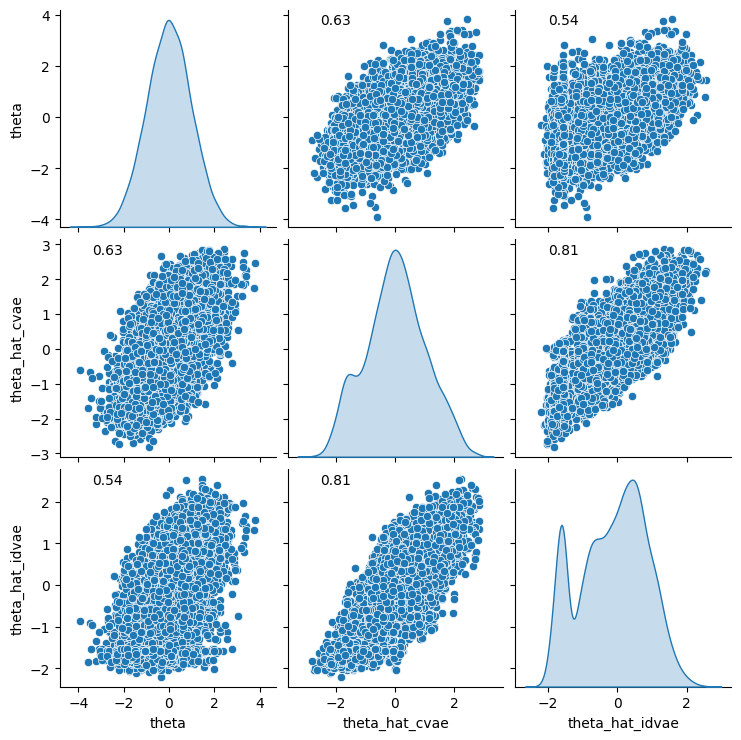

In [24]:
import seaborn as sns

# Combine the arrays into a single DataFrame
data = pd.DataFrame({'theta': theta[:,2], 'theta_hat_cvae': theta_est_c[:,2], 'theta_hat_idvae': theta_est_id[:,2]})

# Create a pairplot using Seaborn
#sns.pairplot(data, corner=True)

# Create a pairplot using Seaborn with correlation coefficients
g = sns.pairplot(data, kind="scatter", diag_kind="kde")

# Calculate correlation coefficients
correlation_matrix = data.corr()

# Annotate correlation coefficients using a heatmap
# Annotate correlation coefficients in the top-left corner of each plot
for i, row in enumerate(correlation_matrix.values):
    for j, value in enumerate(row):
        if i != j:
            x_pos = 0.15  # X-coordinate for annotation
            y_pos = 0.95  # Y-coordinate for annotation
            g.axes[i, j].annotate(f"{value:.2f}", (x_pos, y_pos), xycoords='axes fraction', ha='left', va='center')

# Display the plot
plt.show()



In [338]:
np.savetxt("/Users/karel/Documents/VAE missing/sigma/theta_true_vae.csv", theta, delimiter=',')

In [264]:
thet

array([0.6853, 0.6719, 0.6687, 0.6997, 0.6775, 0.6743, 0.6811])

Text(0, 0.5, 'Estimates')

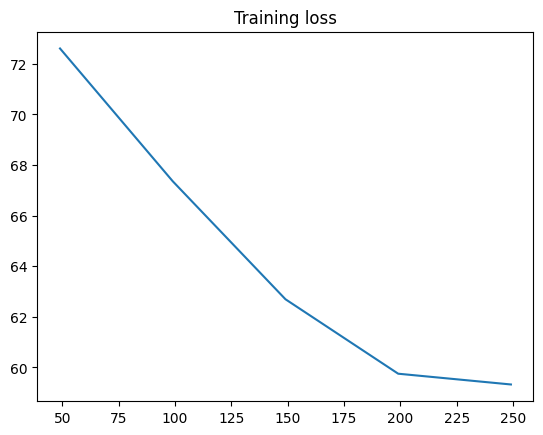

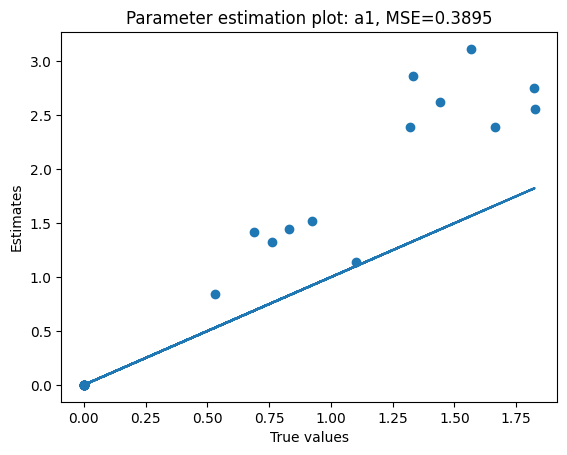

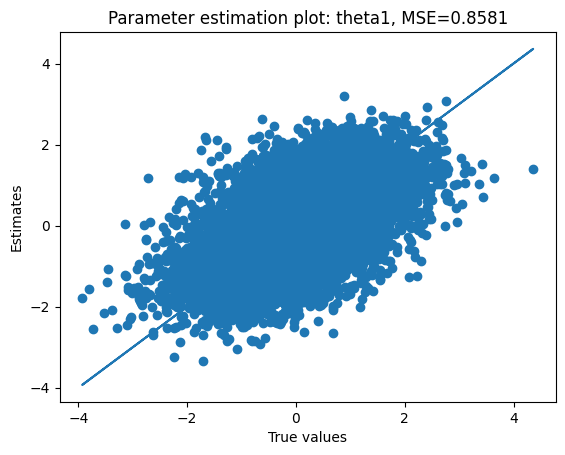

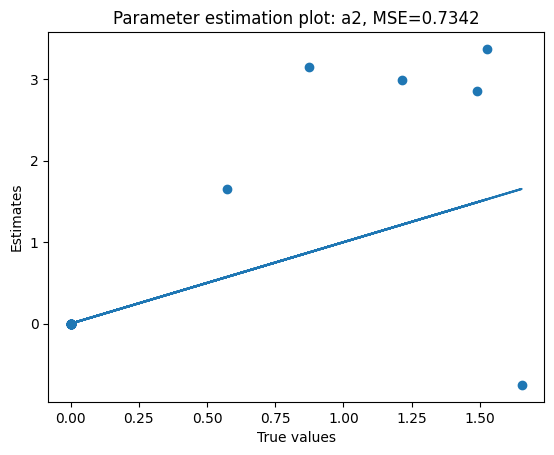

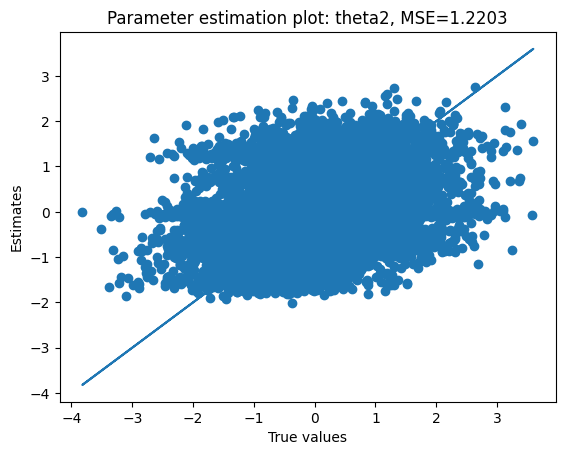

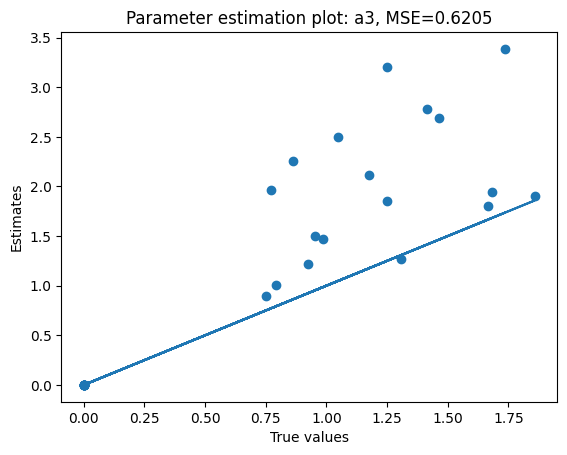

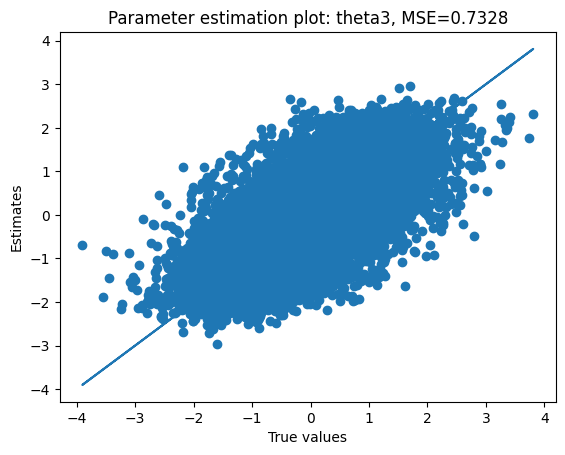

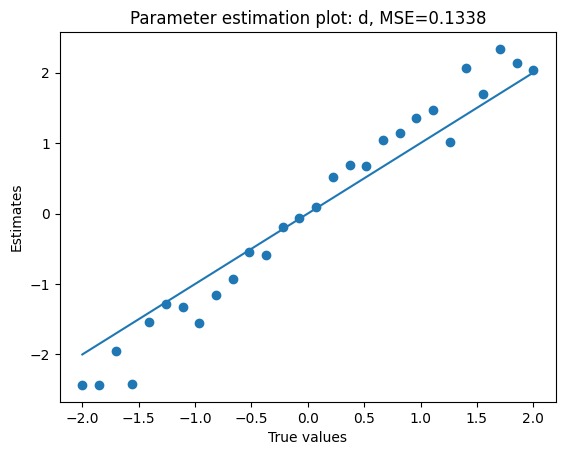

# Planar flows


In [228]:
def EluBackward(x):
    return torch.ones_like(x) * (x >= 0) + torch.exp(x) * (x < 0)
    
class PlanarFlow(pl.LightningModule):
    def __init__(self, latent_dims):
        super(PlanarFlow, self).__init__()
        self.latent_dims = latent_dims
        
        # flow parameters
        self.w = nn.Parameter(torch.randn(1, self.latent_dims))
        self.u = nn.Parameter(torch.randn(1, self.latent_dims))
        self.b = nn.Parameter(torch.randn(1))
        
        # actication function and its derivative
        self.h = F.elu
        self.h_prime = EluBackward
        
        
    def forward(self, z):
        lin = z @ self.w.T + self.b  # [B x 1]
        f = z + self.u * self.h(lin)  # [B x input_dim]
        phi = self.h_prime(lin) @ self.w  # [B x input_dim]
        log_det = torch.log(torch.abs(1 + phi @ self.u.T) + 1e-4).squeeze() 
        
        return f, log_det
        

class RadialFlow(pl.LightningModule):
    def __init__(self, latent_dims):
        super(RadialFlow, self).__init__()
        self.latent_dims = latent_dims
        
        self.x0 = nn.Parameter(torch.randn(1, self.latent_dims))
        self.log_alpha = nn.Parameter(torch.randn(1))
        self.beta = nn.Parameter(torch.randn(1))
        
        # actication function and its derivative
        self.h = F.elu
        self.h_prime = EluBackward
        
        
    def forward(self, z):
        z_sub = z - self.x0
        
        alpha = torch.exp(self.log_alpha)
        beta = -alpha + torch.log(1 + self.beta.exp())  # ensure invertibility
        r = torch.norm(z_sub, dim=-1, keepdim=True)  # [Bx1]
        h = 1 / (alpha + r)  # [Bx1]
        f = z + beta * h * z_sub  # [Bxdim]
        log_det = (self.latent_dims - 1) * torch.log(1 + beta * h) + torch.log(
            1 + beta * h - beta * r / (alpha + r) ** 2
        )
        return f, log_det.squeeze()
    
    
class FlowVAE(pl.LightningModule):
    def __init__(self, latent_dims, qm, dataloader, learning_rate, beta, nitems):
        super(FlowVAE, self).__init__()
        
        self.dataloader = dataloader
        self.latent_dims = latent_dims
        self.lr = learning_rate 
        self.beta = beta
        self.kl = 0 
        self.nitems = nitems
        
        self.encoder = Encoder(28, self.latent_dims, 20, 15)
        self.sampler = SamplingLayer()
        self.decoder = Decoder(28, self.latent_dims, qm)
        
        self.flow = [RadialFlow(self.latent_dims), RadialFlow(self.latent_dims), RadialFlow(self.latent_dims)]
        
    def forward(self, X):
        # Calculate gaussian paramters and sample
        mu, log_sigma = self.encoder(X)
        z = self.sampler(mu, log_sigma)
        z0 = z
        
        #Feed though layers and track determinant terms
        sum_log_det = torch.zeros((z.shape[0],)).to(z.device)
        for layer in self.flow:   
            z, log_det = layer(z)
            sum_log_det += log_det
            
        # Calculate KL
        log_q_z0 = (-0.5 * (log_sigma + torch.pow(z0 - mu, 2) / torch.exp(log_sigma))).sum(dim=1)

        # prior log-density
        log_p_xzk = (-0.5 * torch.pow(z, 2)).sum(dim=1)
        self.kl = log_q_z0 - log_q_z0 - sum_log_det
        
        output = self.decoder(z)
        
        return output
    
    def training_step(self, batch, batch_idx):
        # forward pass

        data, mask = batch
        X_hat = self(data)

        bce = torch.nn.functional.binary_cross_entropy(X_hat, batch[0], reduction='none').sum(dim=-1) 
        # parameter estimation plot for a

        #bce = torch.mean(bce)  * self.nitems
        #bce = bce / torch.mean(mask.float())

        # sum the likelihood and the kl divergence
        #loss = bce + self.beta * self.kl

        loss = (bce + self.kl).mean(dim=0)
        self.log('train_loss',loss)

        return {'loss': loss}
    
    def train_dataloader(self):
        return self.dataloader
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, amsgrad=True)

In [247]:
dataset = SimDataset(data)
train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)

logger = CSVLogger("logs", name='simfit', version=0)
trainer = Trainer(fast_dev_run=cfg['single_epoch_test_run'],
                  max_epochs=cfg['max_epochs'],
                  enable_checkpointing=False, 
                  logger=False, 
                  callbacks=[EarlyStopping(monitor='train_loss', min_delta=cfg['min_delta'], patience=cfg['patience'], mode='min')])


model = FlowVAE(latent_dims=3, qm=Q, dataloader=train_loader, learning_rate=cfg['learning_rate'], beta=cfg['beta'], nitems=28)

start = time.time()
trainer.fit(model)
runtime = time.time()-start

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder       | 991   
1 | sampler | SamplingLayer | 0     
2 | decoder | Decoder       | 112   
------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [174]:
cfg['missing_percentage']

0

tensor(1.2221, grad_fn=<MulBackward0>)

Text(0, 0.5, 'Estimates')

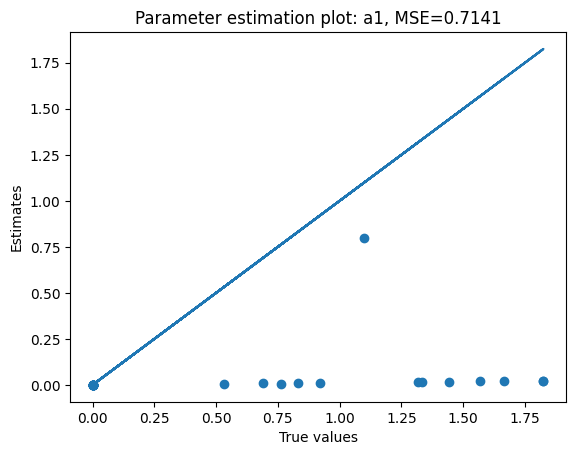

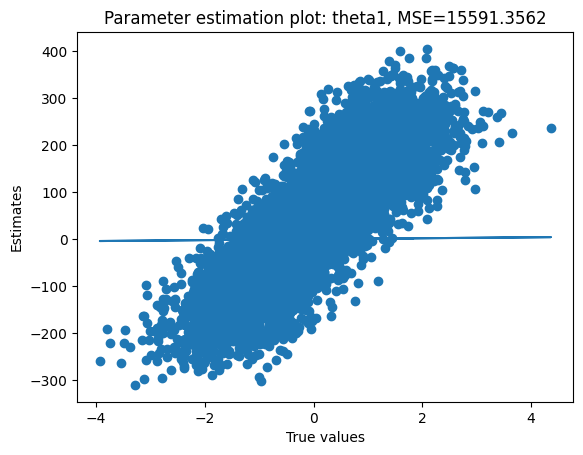

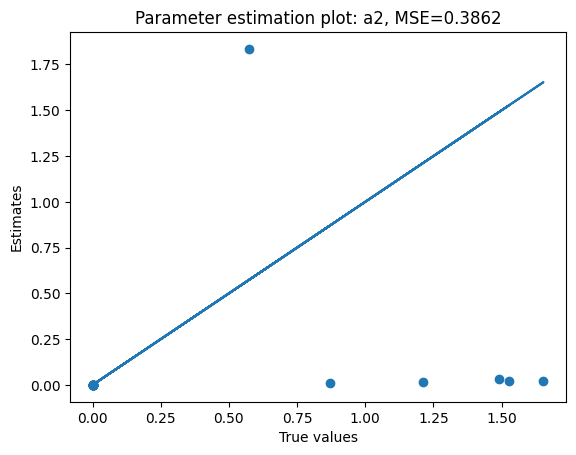

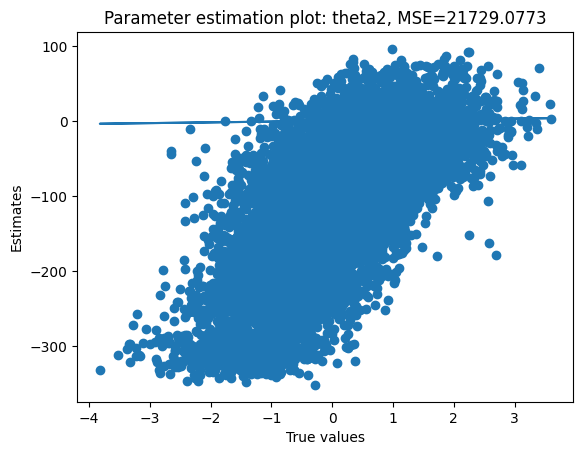

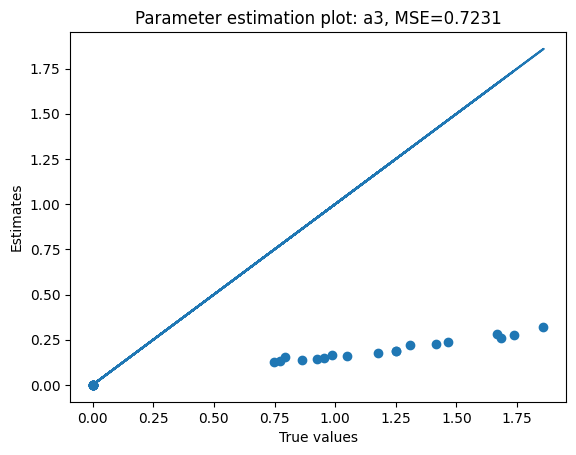

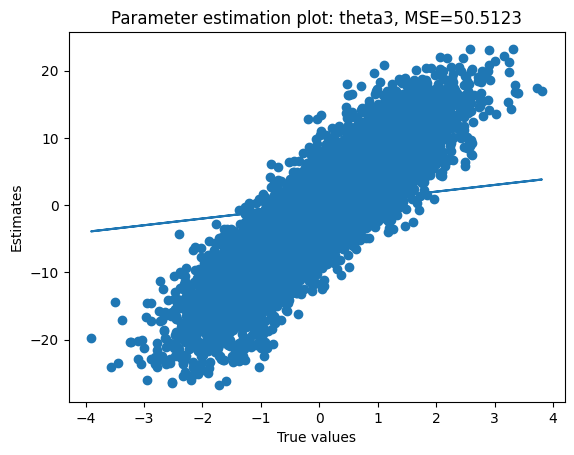

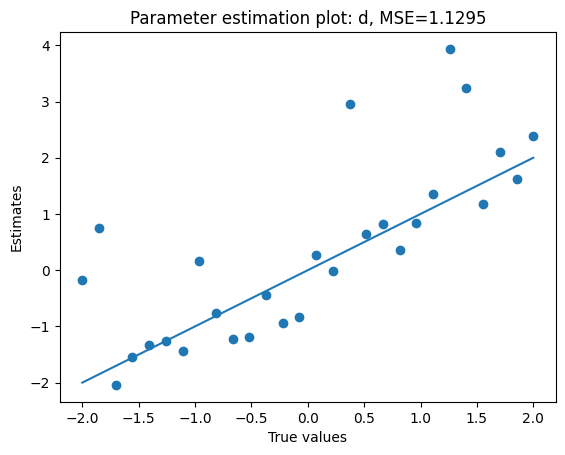

In [248]:
a_est = model.decoder.linear.weight.detach().cpu().numpy()[:, 0:cfg['mirt_dim']]
d_est = model.decoder.linear.bias.detach().cpu().numpy()
model = model.to(device)

dataset = SimDataset(data, device)
train_loader = DataLoader(dataset, batch_size=data.shape[0], shuffle=False)
newdata = next(iter(train_loader))
theta_est, _ = model.encoder(newdata[0])
theta_est = theta_est.detach().cpu().numpy()


# invert factors for increased interpretability
a_est, theta_est = inv_factors(a_est=a_est, theta_est=theta_est, a_true=a)

# parameter estimation plot for a
for dim in range(cfg['mirt_dim']):
    plt.figure()

    ai_est = a_est[:,dim]
    ai_true = a[:,dim]

    mse = MSE(ai_est, ai_true)
    plt.scatter(y=ai_est, x=ai_true)
    plt.plot(ai_true, ai_true)
    #for i, x in enumerate(ai_true):
    #    plt.text(ai_true[i], ai_est[i], i)
    plt.title(f'Parameter estimation plot: a{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')
    plt.savefig(f'./figures/simfit/param_est_plot_a{dim+1}.png')

    # parameter estimation plot for theta
    plt.figure()
    thetai_est = theta_est[:, dim]
    thetai_true = theta[:, dim]
    mse = MSE(thetai_est, thetai_true)
    plt.scatter(y=thetai_est, x=thetai_true)
    plt.plot(thetai_true, thetai_true)
    plt.title(f'Parameter estimation plot: theta{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')
    plt.savefig(f'./figures/simfit/param_est_plot_theta{dim+1}.png')

# parameter estimation plot for d
plt.figure()
plt.scatter(y=d_est, x=b)
plt.plot(b,b)
mse = MSE(d_est, b)
plt.title(f'Parameter estimation plot: d, MSE={round(mse,4)}')
plt.xlabel('True values')
plt.ylabel('Estimates')
#plt.savefig(f'./figures/simfit/param_est_plot_d.png')

In [122]:
import pythae
import torch
import torchvision.datasets as datasets
from pythae.models import VAE_LinNF, VAE_LinNF_Config, VAE, VAEConfig, BetaVAE, BetaVAEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.mnist import Encoder_ResNet_VAE_MNIST, Decoder_ResNet_AE_MNIST
from pythae.models.nn import BaseEncoder, BaseDecoder
from pythae.models.base.base_utils import ModelOutput
device = "cuda" if torch.cuda.is_available() else "cpu"
import math

class My_Decoder(BaseDecoder):
    def __init__(self, latent_dims, nitems, qm=None):
        BaseDecoder.__init__(self)
        # Initialise network components
        input_layer = latent_dims
        self.activation = nn.Sigmoid()
        self.qm = torch.Tensor(qm).t()
        
        # create weights and biases
        self.weights = nn.Parameter(torch.randn(input_layer, nitems))  # Manually created weight matrix
        self.bias = nn.Parameter(torch.zeros(nitems))  # Manually created bias vector
        
        # initialize weights and biases
        stdv = 1. / math.sqrt(self.weights.size(1))
        self.weights.data.uniform_(-stdv, stdv)
        self.weights.data = torch.where(self.qm == 0, torch.zeros_like(self.weights), self.weights)
        self.bias.data.uniform_(-stdv, stdv)
        
       
        
      
    def forward(self, x: torch.Tensor) -> ModelOutput:
        pruned_weights = self.weights * self.qm
        out = torch.matmul(x, pruned_weights) + self.bias
        out = self.activation(out)
        output = ModelOutput(
            reconstruction=out  # Set the output from the decoder in a ModelOutput instance
        )
        return output
    
class My_Encoder(BaseEncoder):
    def __init__(self, latent_dims, nitems, hidden_layer_size, hidden_layer_size2):
        BaseEncoder.__init__(self)
        # initialise netowrk components
        input_layer = nitems

        self.dense1 = nn.Linear(input_layer, hidden_layer_size)
        self.dense2 = nn.Linear(hidden_layer_size, hidden_layer_size2)
        self.densem = nn.Linear(hidden_layer_size2, latent_dims)
        self.denses = nn.Linear(hidden_layer_size2, latent_dims)

       

    def forward(self, x:torch.Tensor) -> ModelOutput:
        out = F.elu(self.dense1(x))
        out = F.elu(self.dense2(out))
        mu =  self.densem(out)
        log_sigma = self.denses(out)


        output = ModelOutput(
            embedding=mu, # Set the output from the decoder in a ModelOutput instance
            log_covariance=2*log_sigma
        )
        return output

# model_config = VAE_LinNF_Config(
#     input_dim=(1, 28),
#     latent_dim=3,
#     flows=['Planar', 'Radial', 'Planar']
#)

config = BaseTrainerConfig(
     output_dir='my_model',
     learning_rate=.005,
     per_device_train_batch_size=10000,
     num_epochs=2000, # Change this to train the model a bit more
)

# model = VAE_LinNF(
#     model_config=model_config,
#     encoder=My_Encoder(3, 28, 20, 10), 
#     decoder=My_Decoder(3, 28, Q)
# )

model_config = VAEConfig(
     output_dir='my_model',
     input_dim=(1, 28),
     latent_dim=6
)

model = VAE(
     model_config=model_config,
     encoder=My_Encoder(3, 28, 20, 10), 
     decoder=My_Decoder(3, 28, Q)
)

pipeline = TrainingPipeline(
    training_config=config,
    model=model
)

pipeline(
    train_data=data
)

Preprocessing train data...
Checking train dataset...
Using Base Trainer

! No eval dataset provided ! -> keeping best model on train.

Model passed sanity check !
Ready for training.

Created my_model/VAE_training_2023-08-02_16-44-48. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 2000
 - per_device_train_batch_size: 10000
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.005
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !



Training of epoch 1/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 7.537
--------------------------------------------------------------------------


Training of epoch 2/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 7.3224
--------------------------------------------------------------------------


Training of epoch 3/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 7.1971
--------------------------------------------------------------------------


Training of epoch 4/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 7.1215
--------------------------------------------------------------------------


Training of epoch 5/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 7.0799
--------------------------------------------------------------------------


Training of epoch 6/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 7.0533
--------------------------------------------------------------------------


Training of epoch 7/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 7.04
--------------------------------------------------------------------------


Training of epoch 8/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 7.0332
--------------------------------------------------------------------------


Training of epoch 9/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 7.0223
--------------------------------------------------------------------------


Training of epoch 10/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 7.0033
--------------------------------------------------------------------------


Training of epoch 11/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.9825
--------------------------------------------------------------------------


Training of epoch 12/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.9608
--------------------------------------------------------------------------


Training of epoch 13/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.9438
--------------------------------------------------------------------------


Training of epoch 14/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.9266
--------------------------------------------------------------------------


Training of epoch 15/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.9125
--------------------------------------------------------------------------


Training of epoch 16/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.8964
--------------------------------------------------------------------------


Training of epoch 17/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.8817
--------------------------------------------------------------------------


Training of epoch 18/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.8679
--------------------------------------------------------------------------


Training of epoch 19/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.8532
--------------------------------------------------------------------------


Training of epoch 20/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.8427
--------------------------------------------------------------------------


Training of epoch 21/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.8302
--------------------------------------------------------------------------


Training of epoch 22/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.8215
--------------------------------------------------------------------------


Training of epoch 23/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.8102
--------------------------------------------------------------------------


Training of epoch 24/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.7988
--------------------------------------------------------------------------


Training of epoch 25/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.7871
--------------------------------------------------------------------------


Training of epoch 26/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.775
--------------------------------------------------------------------------


Training of epoch 27/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.7639
--------------------------------------------------------------------------


Training of epoch 28/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.7531
--------------------------------------------------------------------------


Training of epoch 29/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.7424
--------------------------------------------------------------------------


Training of epoch 30/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.7311
--------------------------------------------------------------------------


Training of epoch 31/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.7223
--------------------------------------------------------------------------


Training of epoch 32/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.7104
--------------------------------------------------------------------------


Training of epoch 33/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.7014
--------------------------------------------------------------------------


Training of epoch 34/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.6918
--------------------------------------------------------------------------


Training of epoch 35/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.6811
--------------------------------------------------------------------------


Training of epoch 36/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.671
--------------------------------------------------------------------------


Training of epoch 37/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.6626
--------------------------------------------------------------------------


Training of epoch 38/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.6531
--------------------------------------------------------------------------


Training of epoch 39/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.6451
--------------------------------------------------------------------------


Training of epoch 40/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.6361
--------------------------------------------------------------------------


Training of epoch 41/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.6275
--------------------------------------------------------------------------


Training of epoch 42/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.6189
--------------------------------------------------------------------------


Training of epoch 43/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.6105
--------------------------------------------------------------------------


Training of epoch 44/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.6013
--------------------------------------------------------------------------


Training of epoch 45/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5934
--------------------------------------------------------------------------


Training of epoch 46/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.585
--------------------------------------------------------------------------


Training of epoch 47/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5779
--------------------------------------------------------------------------


Training of epoch 48/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5686
--------------------------------------------------------------------------


Training of epoch 49/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5605
--------------------------------------------------------------------------


Training of epoch 50/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5522
--------------------------------------------------------------------------


Training of epoch 51/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5444
--------------------------------------------------------------------------


Training of epoch 52/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5356
--------------------------------------------------------------------------


Training of epoch 53/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5295
--------------------------------------------------------------------------


Training of epoch 54/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5219
--------------------------------------------------------------------------


Training of epoch 55/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5133
--------------------------------------------------------------------------


Training of epoch 56/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5072
--------------------------------------------------------------------------


Training of epoch 57/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.5011
--------------------------------------------------------------------------


Training of epoch 58/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4913
--------------------------------------------------------------------------


Training of epoch 59/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4854
--------------------------------------------------------------------------


Training of epoch 60/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4785
--------------------------------------------------------------------------


Training of epoch 61/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4713
--------------------------------------------------------------------------


Training of epoch 62/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4635
--------------------------------------------------------------------------


Training of epoch 63/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4583
--------------------------------------------------------------------------


Training of epoch 64/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4502
--------------------------------------------------------------------------


Training of epoch 65/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4446
--------------------------------------------------------------------------


Training of epoch 66/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4392
--------------------------------------------------------------------------


Training of epoch 67/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.431
--------------------------------------------------------------------------


Training of epoch 68/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4249
--------------------------------------------------------------------------


Training of epoch 69/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4202
--------------------------------------------------------------------------


Training of epoch 70/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4135
--------------------------------------------------------------------------


Training of epoch 71/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4063
--------------------------------------------------------------------------


Training of epoch 72/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.4002
--------------------------------------------------------------------------


Training of epoch 73/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3953
--------------------------------------------------------------------------


Training of epoch 74/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3885
--------------------------------------------------------------------------


Training of epoch 75/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3826
--------------------------------------------------------------------------


Training of epoch 76/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3775
--------------------------------------------------------------------------


Training of epoch 77/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3727
--------------------------------------------------------------------------


Training of epoch 78/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3653
--------------------------------------------------------------------------


Training of epoch 79/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3593
--------------------------------------------------------------------------


Training of epoch 80/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3534
--------------------------------------------------------------------------


Training of epoch 81/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3504
--------------------------------------------------------------------------


Training of epoch 82/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3432
--------------------------------------------------------------------------


Training of epoch 83/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3387
--------------------------------------------------------------------------


Training of epoch 84/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3333
--------------------------------------------------------------------------


Training of epoch 85/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3283
--------------------------------------------------------------------------


Training of epoch 86/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.323
--------------------------------------------------------------------------


Training of epoch 87/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3137
--------------------------------------------------------------------------


Training of epoch 88/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3121
--------------------------------------------------------------------------


Training of epoch 89/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3024
--------------------------------------------------------------------------


Training of epoch 90/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.3001
--------------------------------------------------------------------------


Training of epoch 91/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2975
--------------------------------------------------------------------------


Training of epoch 92/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2951
--------------------------------------------------------------------------


Training of epoch 93/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2869
--------------------------------------------------------------------------


Training of epoch 94/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2821
--------------------------------------------------------------------------


Training of epoch 95/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2768
--------------------------------------------------------------------------


Training of epoch 96/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2733
--------------------------------------------------------------------------


Training of epoch 97/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2677
--------------------------------------------------------------------------


Training of epoch 98/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2644
--------------------------------------------------------------------------


Training of epoch 99/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2585
--------------------------------------------------------------------------


Training of epoch 100/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2546
--------------------------------------------------------------------------


Training of epoch 101/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.251
--------------------------------------------------------------------------


Training of epoch 102/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2435
--------------------------------------------------------------------------


Training of epoch 103/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2407
--------------------------------------------------------------------------


Training of epoch 104/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2368
--------------------------------------------------------------------------


Training of epoch 105/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2317
--------------------------------------------------------------------------


Training of epoch 106/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2317
--------------------------------------------------------------------------


Training of epoch 107/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2268
--------------------------------------------------------------------------


Training of epoch 108/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.218
--------------------------------------------------------------------------


Training of epoch 109/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2147
--------------------------------------------------------------------------


Training of epoch 110/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2125
--------------------------------------------------------------------------


Training of epoch 111/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2092
--------------------------------------------------------------------------


Training of epoch 112/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2038
--------------------------------------------------------------------------


Training of epoch 113/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.2019
--------------------------------------------------------------------------


Training of epoch 114/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1931
--------------------------------------------------------------------------


Training of epoch 115/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1926
--------------------------------------------------------------------------


Training of epoch 116/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1873
--------------------------------------------------------------------------


Training of epoch 117/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1856
--------------------------------------------------------------------------


Training of epoch 118/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1828
--------------------------------------------------------------------------


Training of epoch 119/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1768
--------------------------------------------------------------------------


Training of epoch 120/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1735
--------------------------------------------------------------------------


Training of epoch 121/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1693
--------------------------------------------------------------------------


Training of epoch 122/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1662
--------------------------------------------------------------------------


Training of epoch 123/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.157
--------------------------------------------------------------------------


Training of epoch 124/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1548
--------------------------------------------------------------------------


Training of epoch 125/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1571
--------------------------------------------------------------------------


Training of epoch 126/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1475
--------------------------------------------------------------------------


Training of epoch 127/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1468
--------------------------------------------------------------------------


Training of epoch 128/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1408
--------------------------------------------------------------------------


Training of epoch 129/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1391
--------------------------------------------------------------------------


Training of epoch 130/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1375
--------------------------------------------------------------------------


Training of epoch 131/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1327
--------------------------------------------------------------------------


Training of epoch 132/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1287
--------------------------------------------------------------------------


Training of epoch 133/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.125
--------------------------------------------------------------------------


Training of epoch 134/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1239
--------------------------------------------------------------------------


Training of epoch 135/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1241
--------------------------------------------------------------------------


Training of epoch 136/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1142
--------------------------------------------------------------------------


Training of epoch 137/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1122
--------------------------------------------------------------------------


Training of epoch 138/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1106
--------------------------------------------------------------------------


Training of epoch 139/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1003
--------------------------------------------------------------------------


Training of epoch 140/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0963
--------------------------------------------------------------------------


Training of epoch 141/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.1014
--------------------------------------------------------------------------


Training of epoch 142/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.09
--------------------------------------------------------------------------


Training of epoch 143/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0881
--------------------------------------------------------------------------


Training of epoch 144/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0831
--------------------------------------------------------------------------


Training of epoch 145/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0822
--------------------------------------------------------------------------


Training of epoch 146/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0738
--------------------------------------------------------------------------


Training of epoch 147/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0767
--------------------------------------------------------------------------


Training of epoch 148/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0682
--------------------------------------------------------------------------


Training of epoch 149/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0628
--------------------------------------------------------------------------


Training of epoch 150/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0618
--------------------------------------------------------------------------


Training of epoch 151/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0592
--------------------------------------------------------------------------


Training of epoch 152/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0484
--------------------------------------------------------------------------


Training of epoch 153/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0544
--------------------------------------------------------------------------


Training of epoch 154/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0459
--------------------------------------------------------------------------


Training of epoch 155/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.052
--------------------------------------------------------------------------


Training of epoch 156/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0361
--------------------------------------------------------------------------


Training of epoch 157/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0388
--------------------------------------------------------------------------


Training of epoch 158/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0374
--------------------------------------------------------------------------


Training of epoch 159/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0384
--------------------------------------------------------------------------


Training of epoch 160/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0187
--------------------------------------------------------------------------


Training of epoch 161/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0206
--------------------------------------------------------------------------


Training of epoch 162/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0174
--------------------------------------------------------------------------


Training of epoch 163/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0022
--------------------------------------------------------------------------


Training of epoch 164/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0088
--------------------------------------------------------------------------


Training of epoch 165/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 6.0055
--------------------------------------------------------------------------


Training of epoch 166/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.994
--------------------------------------------------------------------------


Training of epoch 167/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9939
--------------------------------------------------------------------------


Training of epoch 168/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.99
--------------------------------------------------------------------------


Training of epoch 169/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9829
--------------------------------------------------------------------------


Training of epoch 170/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9838
--------------------------------------------------------------------------


Training of epoch 171/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9858
--------------------------------------------------------------------------


Training of epoch 172/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9808
--------------------------------------------------------------------------


Training of epoch 173/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9681
--------------------------------------------------------------------------


Training of epoch 174/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.968
--------------------------------------------------------------------------


Training of epoch 175/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9571
--------------------------------------------------------------------------


Training of epoch 176/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9633
--------------------------------------------------------------------------


Training of epoch 177/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9528
--------------------------------------------------------------------------


Training of epoch 178/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9543
--------------------------------------------------------------------------


Training of epoch 179/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9489
--------------------------------------------------------------------------


Training of epoch 180/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9354
--------------------------------------------------------------------------


Training of epoch 181/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9331
--------------------------------------------------------------------------


Training of epoch 182/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9435
--------------------------------------------------------------------------


Training of epoch 183/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9243
--------------------------------------------------------------------------


Training of epoch 184/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9255
--------------------------------------------------------------------------


Training of epoch 185/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9284
--------------------------------------------------------------------------


Training of epoch 186/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9129
--------------------------------------------------------------------------


Training of epoch 187/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9189
--------------------------------------------------------------------------


Training of epoch 188/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.903
--------------------------------------------------------------------------


Training of epoch 189/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9307
--------------------------------------------------------------------------


Training of epoch 190/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9159
--------------------------------------------------------------------------


Training of epoch 191/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.9018
--------------------------------------------------------------------------


Training of epoch 192/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8908
--------------------------------------------------------------------------


Training of epoch 193/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8888
--------------------------------------------------------------------------


Training of epoch 194/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8834
--------------------------------------------------------------------------


Training of epoch 195/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.893
--------------------------------------------------------------------------


Training of epoch 196/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8866
--------------------------------------------------------------------------


Training of epoch 197/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8844
--------------------------------------------------------------------------


Training of epoch 198/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8881
--------------------------------------------------------------------------


Training of epoch 199/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.869
--------------------------------------------------------------------------


Training of epoch 200/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8868
--------------------------------------------------------------------------


Training of epoch 201/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8837
--------------------------------------------------------------------------


Training of epoch 202/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8761
--------------------------------------------------------------------------


Training of epoch 203/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8795
--------------------------------------------------------------------------


Training of epoch 204/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8606
--------------------------------------------------------------------------


Training of epoch 205/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8764
--------------------------------------------------------------------------


Training of epoch 206/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8868
--------------------------------------------------------------------------


Training of epoch 207/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8637
--------------------------------------------------------------------------


Training of epoch 208/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8591
--------------------------------------------------------------------------


Training of epoch 209/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8626
--------------------------------------------------------------------------


Training of epoch 210/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8656
--------------------------------------------------------------------------


Training of epoch 211/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8521
--------------------------------------------------------------------------


Training of epoch 212/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.853
--------------------------------------------------------------------------


Training of epoch 213/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8479
--------------------------------------------------------------------------


Training of epoch 214/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8506
--------------------------------------------------------------------------


Training of epoch 215/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8592
--------------------------------------------------------------------------


Training of epoch 216/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8434
--------------------------------------------------------------------------


Training of epoch 217/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8494
--------------------------------------------------------------------------


Training of epoch 218/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8536
--------------------------------------------------------------------------


Training of epoch 219/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8492
--------------------------------------------------------------------------


Training of epoch 220/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8408
--------------------------------------------------------------------------


Training of epoch 221/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8503
--------------------------------------------------------------------------


Training of epoch 222/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.843
--------------------------------------------------------------------------


Training of epoch 223/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8409
--------------------------------------------------------------------------


Training of epoch 224/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8335
--------------------------------------------------------------------------


Training of epoch 225/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.821
--------------------------------------------------------------------------


Training of epoch 226/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8316
--------------------------------------------------------------------------


Training of epoch 227/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8297
--------------------------------------------------------------------------


Training of epoch 228/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8119
--------------------------------------------------------------------------


Training of epoch 229/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8177
--------------------------------------------------------------------------


Training of epoch 230/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.819
--------------------------------------------------------------------------


Training of epoch 231/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8208
--------------------------------------------------------------------------


Training of epoch 232/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8312
--------------------------------------------------------------------------


Training of epoch 233/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8239
--------------------------------------------------------------------------


Training of epoch 234/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8147
--------------------------------------------------------------------------


Training of epoch 235/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8187
--------------------------------------------------------------------------


Training of epoch 236/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8055
--------------------------------------------------------------------------


Training of epoch 237/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8112
--------------------------------------------------------------------------


Training of epoch 238/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8226
--------------------------------------------------------------------------


Training of epoch 239/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8104
--------------------------------------------------------------------------


Training of epoch 240/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8083
--------------------------------------------------------------------------


Training of epoch 241/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8134
--------------------------------------------------------------------------


Training of epoch 242/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8059
--------------------------------------------------------------------------


Training of epoch 243/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8046
--------------------------------------------------------------------------


Training of epoch 244/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8094
--------------------------------------------------------------------------


Training of epoch 245/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.793
--------------------------------------------------------------------------


Training of epoch 246/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.818
--------------------------------------------------------------------------


Training of epoch 247/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7953
--------------------------------------------------------------------------


Training of epoch 248/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7935
--------------------------------------------------------------------------


Training of epoch 249/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8127
--------------------------------------------------------------------------


Training of epoch 250/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8103
--------------------------------------------------------------------------


Training of epoch 251/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8043
--------------------------------------------------------------------------


Training of epoch 252/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8049
--------------------------------------------------------------------------


Training of epoch 253/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8106
--------------------------------------------------------------------------


Training of epoch 254/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7977
--------------------------------------------------------------------------


Training of epoch 255/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7942
--------------------------------------------------------------------------


Training of epoch 256/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7855
--------------------------------------------------------------------------


Training of epoch 257/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7887
--------------------------------------------------------------------------


Training of epoch 258/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7978
--------------------------------------------------------------------------


Training of epoch 259/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8003
--------------------------------------------------------------------------


Training of epoch 260/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.8009
--------------------------------------------------------------------------


Training of epoch 261/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7845
--------------------------------------------------------------------------


Training of epoch 262/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7896
--------------------------------------------------------------------------


Training of epoch 263/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7959
--------------------------------------------------------------------------


Training of epoch 264/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7823
--------------------------------------------------------------------------


Training of epoch 265/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7815
--------------------------------------------------------------------------


Training of epoch 266/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7913
--------------------------------------------------------------------------


Training of epoch 267/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.792
--------------------------------------------------------------------------


Training of epoch 268/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7775
--------------------------------------------------------------------------


Training of epoch 269/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7815
--------------------------------------------------------------------------


Training of epoch 270/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7632
--------------------------------------------------------------------------


Training of epoch 271/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7866
--------------------------------------------------------------------------


Training of epoch 272/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7839
--------------------------------------------------------------------------


Training of epoch 273/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7852
--------------------------------------------------------------------------


Training of epoch 274/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7768
--------------------------------------------------------------------------


Training of epoch 275/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7811
--------------------------------------------------------------------------


Training of epoch 276/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7716
--------------------------------------------------------------------------


Training of epoch 277/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7729
--------------------------------------------------------------------------


Training of epoch 278/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7895
--------------------------------------------------------------------------


Training of epoch 279/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7783
--------------------------------------------------------------------------


Training of epoch 280/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7727
--------------------------------------------------------------------------


Training of epoch 281/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7806
--------------------------------------------------------------------------


Training of epoch 282/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7801
--------------------------------------------------------------------------


Training of epoch 283/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7758
--------------------------------------------------------------------------


Training of epoch 284/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7721
--------------------------------------------------------------------------


Training of epoch 285/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.757
--------------------------------------------------------------------------


Training of epoch 286/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7728
--------------------------------------------------------------------------


Training of epoch 287/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7644
--------------------------------------------------------------------------


Training of epoch 288/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7805
--------------------------------------------------------------------------


Training of epoch 289/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7872
--------------------------------------------------------------------------


Training of epoch 290/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7722
--------------------------------------------------------------------------


Training of epoch 291/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7617
--------------------------------------------------------------------------


Training of epoch 292/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7753
--------------------------------------------------------------------------


Training of epoch 293/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7694
--------------------------------------------------------------------------


Training of epoch 294/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7607
--------------------------------------------------------------------------


Training of epoch 295/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7609
--------------------------------------------------------------------------


Training of epoch 296/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7722
--------------------------------------------------------------------------


Training of epoch 297/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7633
--------------------------------------------------------------------------


Training of epoch 298/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7676
--------------------------------------------------------------------------


Training of epoch 299/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7595
--------------------------------------------------------------------------


Training of epoch 300/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.754
--------------------------------------------------------------------------


Training of epoch 301/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7671
--------------------------------------------------------------------------


Training of epoch 302/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7524
--------------------------------------------------------------------------


Training of epoch 303/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.759
--------------------------------------------------------------------------


Training of epoch 304/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7522
--------------------------------------------------------------------------


Training of epoch 305/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7652
--------------------------------------------------------------------------


Training of epoch 306/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7608
--------------------------------------------------------------------------


Training of epoch 307/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7642
--------------------------------------------------------------------------


Training of epoch 308/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7682
--------------------------------------------------------------------------


Training of epoch 309/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.769
--------------------------------------------------------------------------


Training of epoch 310/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7529
--------------------------------------------------------------------------


Training of epoch 311/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7619
--------------------------------------------------------------------------


Training of epoch 312/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7724
--------------------------------------------------------------------------


Training of epoch 313/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7504
--------------------------------------------------------------------------


Training of epoch 314/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7492
--------------------------------------------------------------------------


Training of epoch 315/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.756
--------------------------------------------------------------------------


Training of epoch 316/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7628
--------------------------------------------------------------------------


Training of epoch 317/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7519
--------------------------------------------------------------------------


Training of epoch 318/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7443
--------------------------------------------------------------------------


Training of epoch 319/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7522
--------------------------------------------------------------------------


Training of epoch 320/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.752
--------------------------------------------------------------------------


Training of epoch 321/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7549
--------------------------------------------------------------------------


Training of epoch 322/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7562
--------------------------------------------------------------------------


Training of epoch 323/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7497
--------------------------------------------------------------------------


Training of epoch 324/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7411
--------------------------------------------------------------------------


Training of epoch 325/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7548
--------------------------------------------------------------------------


Training of epoch 326/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.75
--------------------------------------------------------------------------


Training of epoch 327/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7595
--------------------------------------------------------------------------


Training of epoch 328/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7541
--------------------------------------------------------------------------


Training of epoch 329/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7597
--------------------------------------------------------------------------


Training of epoch 330/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7337
--------------------------------------------------------------------------


Training of epoch 331/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7499
--------------------------------------------------------------------------


Training of epoch 332/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7519
--------------------------------------------------------------------------


Training of epoch 333/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.741
--------------------------------------------------------------------------


Training of epoch 334/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7424
--------------------------------------------------------------------------


Training of epoch 335/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7564
--------------------------------------------------------------------------


Training of epoch 336/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7541
--------------------------------------------------------------------------


Training of epoch 337/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7372
--------------------------------------------------------------------------


Training of epoch 338/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7381
--------------------------------------------------------------------------


Training of epoch 339/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7557
--------------------------------------------------------------------------


Training of epoch 340/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7498
--------------------------------------------------------------------------


Training of epoch 341/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7347
--------------------------------------------------------------------------


Training of epoch 342/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7379
--------------------------------------------------------------------------


Training of epoch 343/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7398
--------------------------------------------------------------------------


Training of epoch 344/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7502
--------------------------------------------------------------------------


Training of epoch 345/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7263
--------------------------------------------------------------------------


Training of epoch 346/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7489
--------------------------------------------------------------------------


Training of epoch 347/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7385
--------------------------------------------------------------------------


Training of epoch 348/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7369
--------------------------------------------------------------------------


Training of epoch 349/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7448
--------------------------------------------------------------------------


Training of epoch 350/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.75
--------------------------------------------------------------------------


Training of epoch 351/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7282
--------------------------------------------------------------------------


Training of epoch 352/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.738
--------------------------------------------------------------------------


Training of epoch 353/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7461
--------------------------------------------------------------------------


Training of epoch 354/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7376
--------------------------------------------------------------------------


Training of epoch 355/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7287
--------------------------------------------------------------------------


Training of epoch 356/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7282
--------------------------------------------------------------------------


Training of epoch 357/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7509
--------------------------------------------------------------------------


Training of epoch 358/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7395
--------------------------------------------------------------------------


Training of epoch 359/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7433
--------------------------------------------------------------------------


Training of epoch 360/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7374
--------------------------------------------------------------------------


Training of epoch 361/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7294
--------------------------------------------------------------------------


Training of epoch 362/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7431
--------------------------------------------------------------------------


Training of epoch 363/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7412
--------------------------------------------------------------------------


Training of epoch 364/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7439
--------------------------------------------------------------------------


Training of epoch 365/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7326
--------------------------------------------------------------------------


Training of epoch 366/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7379
--------------------------------------------------------------------------


Training of epoch 367/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.741
--------------------------------------------------------------------------


Training of epoch 368/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7408
--------------------------------------------------------------------------


Training of epoch 369/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7368
--------------------------------------------------------------------------


Training of epoch 370/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7367
--------------------------------------------------------------------------


Training of epoch 371/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7364
--------------------------------------------------------------------------


Training of epoch 372/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7285
--------------------------------------------------------------------------


Training of epoch 373/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7394
--------------------------------------------------------------------------


Training of epoch 374/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7394
--------------------------------------------------------------------------


Training of epoch 375/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.745
--------------------------------------------------------------------------


Training of epoch 376/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7402
--------------------------------------------------------------------------


Training of epoch 377/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7288
--------------------------------------------------------------------------


Training of epoch 378/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7317
--------------------------------------------------------------------------


Training of epoch 379/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7203
--------------------------------------------------------------------------


Training of epoch 380/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7316
--------------------------------------------------------------------------


Training of epoch 381/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7386
--------------------------------------------------------------------------


Training of epoch 382/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7401
--------------------------------------------------------------------------


Training of epoch 383/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.735
--------------------------------------------------------------------------


Training of epoch 384/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7369
--------------------------------------------------------------------------


Training of epoch 385/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7235
--------------------------------------------------------------------------


Training of epoch 386/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.736
--------------------------------------------------------------------------


Training of epoch 387/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7278
--------------------------------------------------------------------------


Training of epoch 388/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7154
--------------------------------------------------------------------------


Training of epoch 389/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7353
--------------------------------------------------------------------------


Training of epoch 390/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7174
--------------------------------------------------------------------------


Training of epoch 391/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7385
--------------------------------------------------------------------------


Training of epoch 392/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7281
--------------------------------------------------------------------------


Training of epoch 393/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7241
--------------------------------------------------------------------------


Training of epoch 394/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.735
--------------------------------------------------------------------------


Training of epoch 395/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7447
--------------------------------------------------------------------------


Training of epoch 396/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7172
--------------------------------------------------------------------------


Training of epoch 397/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7289
--------------------------------------------------------------------------


Training of epoch 398/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7253
--------------------------------------------------------------------------


Training of epoch 399/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7195
--------------------------------------------------------------------------


Training of epoch 400/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7439
--------------------------------------------------------------------------


Training of epoch 401/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7444
--------------------------------------------------------------------------


Training of epoch 402/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7257
--------------------------------------------------------------------------


Training of epoch 403/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7139
--------------------------------------------------------------------------


Training of epoch 404/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7347
--------------------------------------------------------------------------


Training of epoch 405/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7258
--------------------------------------------------------------------------


Training of epoch 406/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7312
--------------------------------------------------------------------------


Training of epoch 407/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7208
--------------------------------------------------------------------------


Training of epoch 408/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7212
--------------------------------------------------------------------------


Training of epoch 409/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7232
--------------------------------------------------------------------------


Training of epoch 410/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7289
--------------------------------------------------------------------------


Training of epoch 411/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.737
--------------------------------------------------------------------------


Training of epoch 412/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7276
--------------------------------------------------------------------------


Training of epoch 413/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7329
--------------------------------------------------------------------------


Training of epoch 414/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7308
--------------------------------------------------------------------------


Training of epoch 415/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7149
--------------------------------------------------------------------------


Training of epoch 416/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.72
--------------------------------------------------------------------------


Training of epoch 417/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7193
--------------------------------------------------------------------------


Training of epoch 418/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.713
--------------------------------------------------------------------------


Training of epoch 419/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7201
--------------------------------------------------------------------------


Training of epoch 420/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7293
--------------------------------------------------------------------------


Training of epoch 421/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7369
--------------------------------------------------------------------------


Training of epoch 422/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.728
--------------------------------------------------------------------------


Training of epoch 423/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7165
--------------------------------------------------------------------------


Training of epoch 424/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7244
--------------------------------------------------------------------------


Training of epoch 425/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7348
--------------------------------------------------------------------------


Training of epoch 426/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7275
--------------------------------------------------------------------------


Training of epoch 427/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7279
--------------------------------------------------------------------------


Training of epoch 428/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7263
--------------------------------------------------------------------------


Training of epoch 429/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7325
--------------------------------------------------------------------------


Training of epoch 430/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7157
--------------------------------------------------------------------------


Training of epoch 431/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7303
--------------------------------------------------------------------------


Training of epoch 432/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7169
--------------------------------------------------------------------------


Training of epoch 433/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7236
--------------------------------------------------------------------------


Training of epoch 434/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7248
--------------------------------------------------------------------------


Training of epoch 435/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7242
--------------------------------------------------------------------------


Training of epoch 436/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7201
--------------------------------------------------------------------------


Training of epoch 437/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7335
--------------------------------------------------------------------------


Training of epoch 438/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7295
--------------------------------------------------------------------------


Training of epoch 439/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.718
--------------------------------------------------------------------------


Training of epoch 440/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7246
--------------------------------------------------------------------------


Training of epoch 441/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7139
--------------------------------------------------------------------------


Training of epoch 442/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7321
--------------------------------------------------------------------------


Training of epoch 443/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7252
--------------------------------------------------------------------------


Training of epoch 444/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7151
--------------------------------------------------------------------------


Training of epoch 445/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7094
--------------------------------------------------------------------------


Training of epoch 446/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7352
--------------------------------------------------------------------------


Training of epoch 447/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7223
--------------------------------------------------------------------------


Training of epoch 448/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7168
--------------------------------------------------------------------------


Training of epoch 449/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7356
--------------------------------------------------------------------------


Training of epoch 450/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7277
--------------------------------------------------------------------------


Training of epoch 451/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7182
--------------------------------------------------------------------------


Training of epoch 452/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7164
--------------------------------------------------------------------------


Training of epoch 453/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7178
--------------------------------------------------------------------------


Training of epoch 454/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7133
--------------------------------------------------------------------------


Training of epoch 455/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7376
--------------------------------------------------------------------------


Training of epoch 456/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7236
--------------------------------------------------------------------------


Training of epoch 457/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7197
--------------------------------------------------------------------------


Training of epoch 458/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7182
--------------------------------------------------------------------------


Training of epoch 459/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7152
--------------------------------------------------------------------------


Training of epoch 460/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.709
--------------------------------------------------------------------------


Training of epoch 461/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7098
--------------------------------------------------------------------------


Training of epoch 462/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7112
--------------------------------------------------------------------------


Training of epoch 463/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7167
--------------------------------------------------------------------------


Training of epoch 464/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7093
--------------------------------------------------------------------------


Training of epoch 465/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7179
--------------------------------------------------------------------------


Training of epoch 466/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7193
--------------------------------------------------------------------------


Training of epoch 467/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7139
--------------------------------------------------------------------------


Training of epoch 468/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7202
--------------------------------------------------------------------------


Training of epoch 469/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7208
--------------------------------------------------------------------------


Training of epoch 470/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7133
--------------------------------------------------------------------------


Training of epoch 471/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7084
--------------------------------------------------------------------------


Training of epoch 472/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7215
--------------------------------------------------------------------------


Training of epoch 473/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7197
--------------------------------------------------------------------------


Training of epoch 474/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7158
--------------------------------------------------------------------------


Training of epoch 475/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7212
--------------------------------------------------------------------------


Training of epoch 476/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7203
--------------------------------------------------------------------------


Training of epoch 477/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7169
--------------------------------------------------------------------------


Training of epoch 478/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7048
--------------------------------------------------------------------------


Training of epoch 479/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7355
--------------------------------------------------------------------------


Training of epoch 480/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6988
--------------------------------------------------------------------------


Training of epoch 481/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7181
--------------------------------------------------------------------------


Training of epoch 482/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7098
--------------------------------------------------------------------------


Training of epoch 483/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7173
--------------------------------------------------------------------------


Training of epoch 484/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.711
--------------------------------------------------------------------------


Training of epoch 485/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7214
--------------------------------------------------------------------------


Training of epoch 486/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7226
--------------------------------------------------------------------------


Training of epoch 487/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 488/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7098
--------------------------------------------------------------------------


Training of epoch 489/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.713
--------------------------------------------------------------------------


Training of epoch 490/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7041
--------------------------------------------------------------------------


Training of epoch 491/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7132
--------------------------------------------------------------------------


Training of epoch 492/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7122
--------------------------------------------------------------------------


Training of epoch 493/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.703
--------------------------------------------------------------------------


Training of epoch 494/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7139
--------------------------------------------------------------------------


Training of epoch 495/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7094
--------------------------------------------------------------------------


Training of epoch 496/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7248
--------------------------------------------------------------------------


Training of epoch 497/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7052
--------------------------------------------------------------------------


Training of epoch 498/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7065
--------------------------------------------------------------------------


Training of epoch 499/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 500/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7299
--------------------------------------------------------------------------


Training of epoch 501/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7189
--------------------------------------------------------------------------


Training of epoch 502/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7091
--------------------------------------------------------------------------


Training of epoch 503/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7144
--------------------------------------------------------------------------


Training of epoch 504/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7027
--------------------------------------------------------------------------


Training of epoch 505/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7165
--------------------------------------------------------------------------


Training of epoch 506/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6803
--------------------------------------------------------------------------


Training of epoch 507/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7175
--------------------------------------------------------------------------


Training of epoch 508/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7169
--------------------------------------------------------------------------


Training of epoch 509/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7145
--------------------------------------------------------------------------


Training of epoch 510/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7151
--------------------------------------------------------------------------


Training of epoch 511/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7001
--------------------------------------------------------------------------


Training of epoch 512/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7171
--------------------------------------------------------------------------


Training of epoch 513/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7155
--------------------------------------------------------------------------


Training of epoch 514/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7315
--------------------------------------------------------------------------


Training of epoch 515/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7101
--------------------------------------------------------------------------


Training of epoch 516/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7215
--------------------------------------------------------------------------


Training of epoch 517/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7107
--------------------------------------------------------------------------


Training of epoch 518/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6977
--------------------------------------------------------------------------


Training of epoch 519/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7159
--------------------------------------------------------------------------


Training of epoch 520/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7148
--------------------------------------------------------------------------


Training of epoch 521/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7055
--------------------------------------------------------------------------


Training of epoch 522/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7062
--------------------------------------------------------------------------


Training of epoch 523/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7184
--------------------------------------------------------------------------


Training of epoch 524/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7182
--------------------------------------------------------------------------


Training of epoch 525/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7209
--------------------------------------------------------------------------


Training of epoch 526/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7073
--------------------------------------------------------------------------


Training of epoch 527/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7229
--------------------------------------------------------------------------


Training of epoch 528/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6973
--------------------------------------------------------------------------


Training of epoch 529/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7175
--------------------------------------------------------------------------


Training of epoch 530/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.721
--------------------------------------------------------------------------


Training of epoch 531/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6995
--------------------------------------------------------------------------


Training of epoch 532/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7064
--------------------------------------------------------------------------


Training of epoch 533/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7034
--------------------------------------------------------------------------


Training of epoch 534/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7126
--------------------------------------------------------------------------


Training of epoch 535/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7009
--------------------------------------------------------------------------


Training of epoch 536/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.71
--------------------------------------------------------------------------


Training of epoch 537/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.723
--------------------------------------------------------------------------


Training of epoch 538/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7086
--------------------------------------------------------------------------


Training of epoch 539/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7063
--------------------------------------------------------------------------


Training of epoch 540/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.714
--------------------------------------------------------------------------


Training of epoch 541/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7021
--------------------------------------------------------------------------


Training of epoch 542/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7109
--------------------------------------------------------------------------


Training of epoch 543/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6994
--------------------------------------------------------------------------


Training of epoch 544/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7081
--------------------------------------------------------------------------


Training of epoch 545/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7023
--------------------------------------------------------------------------


Training of epoch 546/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7172
--------------------------------------------------------------------------


Training of epoch 547/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7076
--------------------------------------------------------------------------


Training of epoch 548/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7053
--------------------------------------------------------------------------


Training of epoch 549/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7301
--------------------------------------------------------------------------


Training of epoch 550/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7154
--------------------------------------------------------------------------


Training of epoch 551/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7132
--------------------------------------------------------------------------


Training of epoch 552/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6916
--------------------------------------------------------------------------


Training of epoch 553/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6938
--------------------------------------------------------------------------


Training of epoch 554/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7248
--------------------------------------------------------------------------


Training of epoch 555/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.714
--------------------------------------------------------------------------


Training of epoch 556/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6998
--------------------------------------------------------------------------


Training of epoch 557/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7177
--------------------------------------------------------------------------


Training of epoch 558/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7095
--------------------------------------------------------------------------


Training of epoch 559/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7083
--------------------------------------------------------------------------


Training of epoch 560/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7203
--------------------------------------------------------------------------


Training of epoch 561/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7021
--------------------------------------------------------------------------


Training of epoch 562/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7148
--------------------------------------------------------------------------


Training of epoch 563/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7091
--------------------------------------------------------------------------


Training of epoch 564/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7018
--------------------------------------------------------------------------


Training of epoch 565/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7071
--------------------------------------------------------------------------


Training of epoch 566/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6992
--------------------------------------------------------------------------


Training of epoch 567/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7005
--------------------------------------------------------------------------


Training of epoch 568/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7034
--------------------------------------------------------------------------


Training of epoch 569/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7042
--------------------------------------------------------------------------


Training of epoch 570/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7034
--------------------------------------------------------------------------


Training of epoch 571/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7174
--------------------------------------------------------------------------


Training of epoch 572/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6969
--------------------------------------------------------------------------


Training of epoch 573/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7098
--------------------------------------------------------------------------


Training of epoch 574/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7079
--------------------------------------------------------------------------


Training of epoch 575/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7088
--------------------------------------------------------------------------


Training of epoch 576/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7051
--------------------------------------------------------------------------


Training of epoch 577/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7028
--------------------------------------------------------------------------


Training of epoch 578/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 579/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7103
--------------------------------------------------------------------------


Training of epoch 580/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.708
--------------------------------------------------------------------------


Training of epoch 581/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7052
--------------------------------------------------------------------------


Training of epoch 582/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7099
--------------------------------------------------------------------------


Training of epoch 583/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7166
--------------------------------------------------------------------------


Training of epoch 584/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7197
--------------------------------------------------------------------------


Training of epoch 585/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6999
--------------------------------------------------------------------------


Training of epoch 586/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7158
--------------------------------------------------------------------------


Training of epoch 587/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6836
--------------------------------------------------------------------------


Training of epoch 588/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7145
--------------------------------------------------------------------------


Training of epoch 589/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7121
--------------------------------------------------------------------------


Training of epoch 590/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6967
--------------------------------------------------------------------------


Training of epoch 591/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7209
--------------------------------------------------------------------------


Training of epoch 592/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7172
--------------------------------------------------------------------------


Training of epoch 593/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7076
--------------------------------------------------------------------------


Training of epoch 594/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7106
--------------------------------------------------------------------------


Training of epoch 595/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7096
--------------------------------------------------------------------------


Training of epoch 596/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6977
--------------------------------------------------------------------------


Training of epoch 597/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7167
--------------------------------------------------------------------------


Training of epoch 598/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7142
--------------------------------------------------------------------------


Training of epoch 599/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6965
--------------------------------------------------------------------------


Training of epoch 600/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7072
--------------------------------------------------------------------------


Training of epoch 601/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7105
--------------------------------------------------------------------------


Training of epoch 602/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7061
--------------------------------------------------------------------------


Training of epoch 603/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7116
--------------------------------------------------------------------------


Training of epoch 604/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7093
--------------------------------------------------------------------------


Training of epoch 605/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7084
--------------------------------------------------------------------------


Training of epoch 606/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7023
--------------------------------------------------------------------------


Training of epoch 607/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 608/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7156
--------------------------------------------------------------------------


Training of epoch 609/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7127
--------------------------------------------------------------------------


Training of epoch 610/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7018
--------------------------------------------------------------------------


Training of epoch 611/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7062
--------------------------------------------------------------------------


Training of epoch 612/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6991
--------------------------------------------------------------------------


Training of epoch 613/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7124
--------------------------------------------------------------------------


Training of epoch 614/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7009
--------------------------------------------------------------------------


Training of epoch 615/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7085
--------------------------------------------------------------------------


Training of epoch 616/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.696
--------------------------------------------------------------------------


Training of epoch 617/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6902
--------------------------------------------------------------------------


Training of epoch 618/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7025
--------------------------------------------------------------------------


Training of epoch 619/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7132
--------------------------------------------------------------------------


Training of epoch 620/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7087
--------------------------------------------------------------------------


Training of epoch 621/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7036
--------------------------------------------------------------------------


Training of epoch 622/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7086
--------------------------------------------------------------------------


Training of epoch 623/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7096
--------------------------------------------------------------------------


Training of epoch 624/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7081
--------------------------------------------------------------------------


Training of epoch 625/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7023
--------------------------------------------------------------------------


Training of epoch 626/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6985
--------------------------------------------------------------------------


Training of epoch 627/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.712
--------------------------------------------------------------------------


Training of epoch 628/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6913
--------------------------------------------------------------------------


Training of epoch 629/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7218
--------------------------------------------------------------------------


Training of epoch 630/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6977
--------------------------------------------------------------------------


Training of epoch 631/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6997
--------------------------------------------------------------------------


Training of epoch 632/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7
--------------------------------------------------------------------------


Training of epoch 633/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7273
--------------------------------------------------------------------------


Training of epoch 634/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7243
--------------------------------------------------------------------------


Training of epoch 635/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7089
--------------------------------------------------------------------------


Training of epoch 636/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7111
--------------------------------------------------------------------------


Training of epoch 637/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7023
--------------------------------------------------------------------------


Training of epoch 638/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7
--------------------------------------------------------------------------


Training of epoch 639/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7173
--------------------------------------------------------------------------


Training of epoch 640/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7029
--------------------------------------------------------------------------


Training of epoch 641/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7136
--------------------------------------------------------------------------


Training of epoch 642/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7016
--------------------------------------------------------------------------


Training of epoch 643/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6994
--------------------------------------------------------------------------


Training of epoch 644/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.712
--------------------------------------------------------------------------


Training of epoch 645/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7058
--------------------------------------------------------------------------


Training of epoch 646/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7122
--------------------------------------------------------------------------


Training of epoch 647/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7038
--------------------------------------------------------------------------


Training of epoch 648/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7092
--------------------------------------------------------------------------


Training of epoch 649/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7072
--------------------------------------------------------------------------


Training of epoch 650/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7067
--------------------------------------------------------------------------


Training of epoch 651/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6935
--------------------------------------------------------------------------


Training of epoch 652/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7148
--------------------------------------------------------------------------


Training of epoch 653/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7014
--------------------------------------------------------------------------


Training of epoch 654/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.689
--------------------------------------------------------------------------


Training of epoch 655/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7085
--------------------------------------------------------------------------


Training of epoch 656/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7001
--------------------------------------------------------------------------


Training of epoch 657/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.709
--------------------------------------------------------------------------


Training of epoch 658/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7061
--------------------------------------------------------------------------


Training of epoch 659/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7128
--------------------------------------------------------------------------


Training of epoch 660/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6946
--------------------------------------------------------------------------


Training of epoch 661/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.718
--------------------------------------------------------------------------


Training of epoch 662/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7129
--------------------------------------------------------------------------


Training of epoch 663/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.691
--------------------------------------------------------------------------


Training of epoch 664/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7014
--------------------------------------------------------------------------


Training of epoch 665/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7172
--------------------------------------------------------------------------


Training of epoch 666/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7136
--------------------------------------------------------------------------


Training of epoch 667/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6985
--------------------------------------------------------------------------


Training of epoch 668/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.702
--------------------------------------------------------------------------


Training of epoch 669/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6934
--------------------------------------------------------------------------


Training of epoch 670/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6969
--------------------------------------------------------------------------


Training of epoch 671/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7182
--------------------------------------------------------------------------


Training of epoch 672/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7045
--------------------------------------------------------------------------


Training of epoch 673/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.715
--------------------------------------------------------------------------


Training of epoch 674/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7062
--------------------------------------------------------------------------


Training of epoch 675/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7142
--------------------------------------------------------------------------


Training of epoch 676/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7101
--------------------------------------------------------------------------


Training of epoch 677/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6949
--------------------------------------------------------------------------


Training of epoch 678/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6942
--------------------------------------------------------------------------


Training of epoch 679/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7038
--------------------------------------------------------------------------


Training of epoch 680/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6954
--------------------------------------------------------------------------


Training of epoch 681/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7176
--------------------------------------------------------------------------


Training of epoch 682/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.71
--------------------------------------------------------------------------


Training of epoch 683/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7248
--------------------------------------------------------------------------


Training of epoch 684/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6968
--------------------------------------------------------------------------


Training of epoch 685/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6937
--------------------------------------------------------------------------


Training of epoch 686/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7109
--------------------------------------------------------------------------


Training of epoch 687/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7012
--------------------------------------------------------------------------


Training of epoch 688/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6858
--------------------------------------------------------------------------


Training of epoch 689/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7105
--------------------------------------------------------------------------


Training of epoch 690/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7114
--------------------------------------------------------------------------


Training of epoch 691/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.715
--------------------------------------------------------------------------


Training of epoch 692/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7055
--------------------------------------------------------------------------


Training of epoch 693/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7027
--------------------------------------------------------------------------


Training of epoch 694/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7044
--------------------------------------------------------------------------


Training of epoch 695/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7076
--------------------------------------------------------------------------


Training of epoch 696/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7148
--------------------------------------------------------------------------


Training of epoch 697/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7062
--------------------------------------------------------------------------


Training of epoch 698/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7072
--------------------------------------------------------------------------


Training of epoch 699/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7016
--------------------------------------------------------------------------


Training of epoch 700/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7177
--------------------------------------------------------------------------


Training of epoch 701/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7154
--------------------------------------------------------------------------


Training of epoch 702/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7003
--------------------------------------------------------------------------


Training of epoch 703/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7016
--------------------------------------------------------------------------


Training of epoch 704/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7222
--------------------------------------------------------------------------


Training of epoch 705/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7179
--------------------------------------------------------------------------


Training of epoch 706/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6945
--------------------------------------------------------------------------


Training of epoch 707/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7003
--------------------------------------------------------------------------


Training of epoch 708/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7012
--------------------------------------------------------------------------


Training of epoch 709/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7099
--------------------------------------------------------------------------


Training of epoch 710/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.703
--------------------------------------------------------------------------


Training of epoch 711/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 712/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7053
--------------------------------------------------------------------------


Training of epoch 713/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7058
--------------------------------------------------------------------------


Training of epoch 714/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7062
--------------------------------------------------------------------------


Training of epoch 715/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6974
--------------------------------------------------------------------------


Training of epoch 716/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7033
--------------------------------------------------------------------------


Training of epoch 717/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6993
--------------------------------------------------------------------------


Training of epoch 718/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7085
--------------------------------------------------------------------------


Training of epoch 719/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7085
--------------------------------------------------------------------------


Training of epoch 720/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6937
--------------------------------------------------------------------------


Training of epoch 721/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6997
--------------------------------------------------------------------------


Training of epoch 722/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7007
--------------------------------------------------------------------------


Training of epoch 723/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7066
--------------------------------------------------------------------------


Training of epoch 724/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7126
--------------------------------------------------------------------------


Training of epoch 725/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7045
--------------------------------------------------------------------------


Training of epoch 726/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7091
--------------------------------------------------------------------------


Training of epoch 727/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7052
--------------------------------------------------------------------------


Training of epoch 728/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.715
--------------------------------------------------------------------------


Training of epoch 729/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7032
--------------------------------------------------------------------------


Training of epoch 730/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7081
--------------------------------------------------------------------------


Training of epoch 731/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7006
--------------------------------------------------------------------------


Training of epoch 732/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6946
--------------------------------------------------------------------------


Training of epoch 733/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6993
--------------------------------------------------------------------------


Training of epoch 734/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6872
--------------------------------------------------------------------------


Training of epoch 735/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7032
--------------------------------------------------------------------------


Training of epoch 736/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7014
--------------------------------------------------------------------------


Training of epoch 737/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7024
--------------------------------------------------------------------------


Training of epoch 738/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7053
--------------------------------------------------------------------------


Training of epoch 739/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7068
--------------------------------------------------------------------------


Training of epoch 740/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6928
--------------------------------------------------------------------------


Training of epoch 741/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6967
--------------------------------------------------------------------------


Training of epoch 742/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7137
--------------------------------------------------------------------------


Training of epoch 743/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7053
--------------------------------------------------------------------------


Training of epoch 744/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7057
--------------------------------------------------------------------------


Training of epoch 745/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7066
--------------------------------------------------------------------------


Training of epoch 746/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.706
--------------------------------------------------------------------------


Training of epoch 747/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 748/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6936
--------------------------------------------------------------------------


Training of epoch 749/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7056
--------------------------------------------------------------------------


Training of epoch 750/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7081
--------------------------------------------------------------------------


Training of epoch 751/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 752/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7155
--------------------------------------------------------------------------


Training of epoch 753/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7125
--------------------------------------------------------------------------


Training of epoch 754/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 755/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6958
--------------------------------------------------------------------------


Training of epoch 756/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7021
--------------------------------------------------------------------------


Training of epoch 757/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7083
--------------------------------------------------------------------------


Training of epoch 758/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7004
--------------------------------------------------------------------------


Training of epoch 759/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7107
--------------------------------------------------------------------------


Training of epoch 760/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7041
--------------------------------------------------------------------------


Training of epoch 761/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7072
--------------------------------------------------------------------------


Training of epoch 762/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7024
--------------------------------------------------------------------------


Training of epoch 763/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7062
--------------------------------------------------------------------------


Training of epoch 764/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.721
--------------------------------------------------------------------------


Training of epoch 765/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6903
--------------------------------------------------------------------------


Training of epoch 766/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.702
--------------------------------------------------------------------------


Training of epoch 767/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.702
--------------------------------------------------------------------------


Training of epoch 768/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 769/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6917
--------------------------------------------------------------------------


Training of epoch 770/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6994
--------------------------------------------------------------------------


Training of epoch 771/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7038
--------------------------------------------------------------------------


Training of epoch 772/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6991
--------------------------------------------------------------------------


Training of epoch 773/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.703
--------------------------------------------------------------------------


Training of epoch 774/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7053
--------------------------------------------------------------------------


Training of epoch 775/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7059
--------------------------------------------------------------------------


Training of epoch 776/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7094
--------------------------------------------------------------------------


Training of epoch 777/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7089
--------------------------------------------------------------------------


Training of epoch 778/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7076
--------------------------------------------------------------------------


Training of epoch 779/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6968
--------------------------------------------------------------------------


Training of epoch 780/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7076
--------------------------------------------------------------------------


Training of epoch 781/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6905
--------------------------------------------------------------------------


Training of epoch 782/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7025
--------------------------------------------------------------------------


Training of epoch 783/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7021
--------------------------------------------------------------------------


Training of epoch 784/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6952
--------------------------------------------------------------------------


Training of epoch 785/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6991
--------------------------------------------------------------------------


Training of epoch 786/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.699
--------------------------------------------------------------------------


Training of epoch 787/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7077
--------------------------------------------------------------------------


Training of epoch 788/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.704
--------------------------------------------------------------------------


Training of epoch 789/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7047
--------------------------------------------------------------------------


Training of epoch 790/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7114
--------------------------------------------------------------------------


Training of epoch 791/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6873
--------------------------------------------------------------------------


Training of epoch 792/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6998
--------------------------------------------------------------------------


Training of epoch 793/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7133
--------------------------------------------------------------------------


Training of epoch 794/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6996
--------------------------------------------------------------------------


Training of epoch 795/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6893
--------------------------------------------------------------------------


Training of epoch 796/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6984
--------------------------------------------------------------------------


Training of epoch 797/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7028
--------------------------------------------------------------------------


Training of epoch 798/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7202
--------------------------------------------------------------------------


Training of epoch 799/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6892
--------------------------------------------------------------------------


Training of epoch 800/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7027
--------------------------------------------------------------------------


Training of epoch 801/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7054
--------------------------------------------------------------------------


Training of epoch 802/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7121
--------------------------------------------------------------------------


Training of epoch 803/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6988
--------------------------------------------------------------------------


Training of epoch 804/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7088
--------------------------------------------------------------------------


Training of epoch 805/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7022
--------------------------------------------------------------------------


Training of epoch 806/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7133
--------------------------------------------------------------------------


Training of epoch 807/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7093
--------------------------------------------------------------------------


Training of epoch 808/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7089
--------------------------------------------------------------------------


Training of epoch 809/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7033
--------------------------------------------------------------------------


Training of epoch 810/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6904
--------------------------------------------------------------------------


Training of epoch 811/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6932
--------------------------------------------------------------------------


Training of epoch 812/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7003
--------------------------------------------------------------------------


Training of epoch 813/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6977
--------------------------------------------------------------------------


Training of epoch 814/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7129
--------------------------------------------------------------------------


Training of epoch 815/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6921
--------------------------------------------------------------------------


Training of epoch 816/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6937
--------------------------------------------------------------------------


Training of epoch 817/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7062
--------------------------------------------------------------------------


Training of epoch 818/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6948
--------------------------------------------------------------------------


Training of epoch 819/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7019
--------------------------------------------------------------------------


Training of epoch 820/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7107
--------------------------------------------------------------------------


Training of epoch 821/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6988
--------------------------------------------------------------------------


Training of epoch 822/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6999
--------------------------------------------------------------------------


Training of epoch 823/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7005
--------------------------------------------------------------------------


Training of epoch 824/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6906
--------------------------------------------------------------------------


Training of epoch 825/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6956
--------------------------------------------------------------------------


Training of epoch 826/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 827/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7024
--------------------------------------------------------------------------


Training of epoch 828/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7051
--------------------------------------------------------------------------


Training of epoch 829/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7
--------------------------------------------------------------------------


Training of epoch 830/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7097
--------------------------------------------------------------------------


Training of epoch 831/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6924
--------------------------------------------------------------------------


Training of epoch 832/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.696
--------------------------------------------------------------------------


Training of epoch 833/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.695
--------------------------------------------------------------------------


Training of epoch 834/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7106
--------------------------------------------------------------------------


Training of epoch 835/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6976
--------------------------------------------------------------------------


Training of epoch 836/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7129
--------------------------------------------------------------------------


Training of epoch 837/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7032
--------------------------------------------------------------------------


Training of epoch 838/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6928
--------------------------------------------------------------------------


Training of epoch 839/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7013
--------------------------------------------------------------------------


Training of epoch 840/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7053
--------------------------------------------------------------------------


Training of epoch 841/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6939
--------------------------------------------------------------------------


Training of epoch 842/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6947
--------------------------------------------------------------------------


Training of epoch 843/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 844/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6966
--------------------------------------------------------------------------


Training of epoch 845/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6905
--------------------------------------------------------------------------


Training of epoch 846/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6935
--------------------------------------------------------------------------


Training of epoch 847/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6968
--------------------------------------------------------------------------


Training of epoch 848/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6954
--------------------------------------------------------------------------


Training of epoch 849/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 850/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6971
--------------------------------------------------------------------------


Training of epoch 851/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7195
--------------------------------------------------------------------------


Training of epoch 852/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 853/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7044
--------------------------------------------------------------------------


Training of epoch 854/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6919
--------------------------------------------------------------------------


Training of epoch 855/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6997
--------------------------------------------------------------------------


Training of epoch 856/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7175
--------------------------------------------------------------------------


Training of epoch 857/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7121
--------------------------------------------------------------------------


Training of epoch 858/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 859/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7057
--------------------------------------------------------------------------


Training of epoch 860/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7067
--------------------------------------------------------------------------


Training of epoch 861/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7103
--------------------------------------------------------------------------


Training of epoch 862/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7022
--------------------------------------------------------------------------


Training of epoch 863/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7062
--------------------------------------------------------------------------


Training of epoch 864/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7148
--------------------------------------------------------------------------


Training of epoch 865/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6956
--------------------------------------------------------------------------


Training of epoch 866/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 867/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7102
--------------------------------------------------------------------------


Training of epoch 868/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7051
--------------------------------------------------------------------------


Training of epoch 869/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6904
--------------------------------------------------------------------------


Training of epoch 870/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7046
--------------------------------------------------------------------------


Training of epoch 871/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.706
--------------------------------------------------------------------------


Training of epoch 872/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6989
--------------------------------------------------------------------------


Training of epoch 873/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.691
--------------------------------------------------------------------------


Training of epoch 874/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.694
--------------------------------------------------------------------------


Training of epoch 875/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6887
--------------------------------------------------------------------------


Training of epoch 876/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7059
--------------------------------------------------------------------------


Training of epoch 877/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7092
--------------------------------------------------------------------------


Training of epoch 878/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7066
--------------------------------------------------------------------------


Training of epoch 879/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7013
--------------------------------------------------------------------------


Training of epoch 880/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7032
--------------------------------------------------------------------------


Training of epoch 881/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.708
--------------------------------------------------------------------------


Training of epoch 882/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7035
--------------------------------------------------------------------------


Training of epoch 883/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7062
--------------------------------------------------------------------------


Training of epoch 884/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6831
--------------------------------------------------------------------------


Training of epoch 885/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7112
--------------------------------------------------------------------------


Training of epoch 886/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6944
--------------------------------------------------------------------------


Training of epoch 887/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7026
--------------------------------------------------------------------------


Training of epoch 888/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6959
--------------------------------------------------------------------------


Training of epoch 889/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7076
--------------------------------------------------------------------------


Training of epoch 890/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7059
--------------------------------------------------------------------------


Training of epoch 891/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7218
--------------------------------------------------------------------------


Training of epoch 892/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 893/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6938
--------------------------------------------------------------------------


Training of epoch 894/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6972
--------------------------------------------------------------------------


Training of epoch 895/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7149
--------------------------------------------------------------------------


Training of epoch 896/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6987
--------------------------------------------------------------------------


Training of epoch 897/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7045
--------------------------------------------------------------------------


Training of epoch 898/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6986
--------------------------------------------------------------------------


Training of epoch 899/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 900/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6883
--------------------------------------------------------------------------


Training of epoch 901/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7078
--------------------------------------------------------------------------


Training of epoch 902/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6911
--------------------------------------------------------------------------


Training of epoch 903/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6861
--------------------------------------------------------------------------


Training of epoch 904/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7133
--------------------------------------------------------------------------


Training of epoch 905/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6982
--------------------------------------------------------------------------


Training of epoch 906/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7083
--------------------------------------------------------------------------


Training of epoch 907/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7084
--------------------------------------------------------------------------


Training of epoch 908/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7108
--------------------------------------------------------------------------


Training of epoch 909/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6963
--------------------------------------------------------------------------


Training of epoch 910/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6993
--------------------------------------------------------------------------


Training of epoch 911/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6972
--------------------------------------------------------------------------


Training of epoch 912/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6995
--------------------------------------------------------------------------


Training of epoch 913/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6898
--------------------------------------------------------------------------


Training of epoch 914/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7107
--------------------------------------------------------------------------


Training of epoch 915/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7038
--------------------------------------------------------------------------


Training of epoch 916/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7036
--------------------------------------------------------------------------


Training of epoch 917/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 918/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7053
--------------------------------------------------------------------------


Training of epoch 919/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6926
--------------------------------------------------------------------------


Training of epoch 920/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7024
--------------------------------------------------------------------------


Training of epoch 921/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7044
--------------------------------------------------------------------------


Training of epoch 922/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6984
--------------------------------------------------------------------------


Training of epoch 923/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7037
--------------------------------------------------------------------------


Training of epoch 924/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6917
--------------------------------------------------------------------------


Training of epoch 925/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 926/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 927/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6969
--------------------------------------------------------------------------


Training of epoch 928/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6909
--------------------------------------------------------------------------


Training of epoch 929/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7163
--------------------------------------------------------------------------


Training of epoch 930/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7027
--------------------------------------------------------------------------


Training of epoch 931/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7007
--------------------------------------------------------------------------


Training of epoch 932/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6952
--------------------------------------------------------------------------


Training of epoch 933/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7064
--------------------------------------------------------------------------


Training of epoch 934/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6993
--------------------------------------------------------------------------


Training of epoch 935/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6957
--------------------------------------------------------------------------


Training of epoch 936/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6977
--------------------------------------------------------------------------


Training of epoch 937/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7044
--------------------------------------------------------------------------


Training of epoch 938/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6997
--------------------------------------------------------------------------


Training of epoch 939/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7035
--------------------------------------------------------------------------


Training of epoch 940/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7122
--------------------------------------------------------------------------


Training of epoch 941/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 942/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7049
--------------------------------------------------------------------------


Training of epoch 943/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7126
--------------------------------------------------------------------------


Training of epoch 944/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6934
--------------------------------------------------------------------------


Training of epoch 945/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6995
--------------------------------------------------------------------------


Training of epoch 946/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7068
--------------------------------------------------------------------------


Training of epoch 947/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 948/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6941
--------------------------------------------------------------------------


Training of epoch 949/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7174
--------------------------------------------------------------------------


Training of epoch 950/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7177
--------------------------------------------------------------------------


Training of epoch 951/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6985
--------------------------------------------------------------------------


Training of epoch 952/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7145
--------------------------------------------------------------------------


Training of epoch 953/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6997
--------------------------------------------------------------------------


Training of epoch 954/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6877
--------------------------------------------------------------------------


Training of epoch 955/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6929
--------------------------------------------------------------------------


Training of epoch 956/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.699
--------------------------------------------------------------------------


Training of epoch 957/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6941
--------------------------------------------------------------------------


Training of epoch 958/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7033
--------------------------------------------------------------------------


Training of epoch 959/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7036
--------------------------------------------------------------------------


Training of epoch 960/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7089
--------------------------------------------------------------------------


Training of epoch 961/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7001
--------------------------------------------------------------------------


Training of epoch 962/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7012
--------------------------------------------------------------------------


Training of epoch 963/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7053
--------------------------------------------------------------------------


Training of epoch 964/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6967
--------------------------------------------------------------------------


Training of epoch 965/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6985
--------------------------------------------------------------------------


Training of epoch 966/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6898
--------------------------------------------------------------------------


Training of epoch 967/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6961
--------------------------------------------------------------------------


Training of epoch 968/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7078
--------------------------------------------------------------------------


Training of epoch 969/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6941
--------------------------------------------------------------------------


Training of epoch 970/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7001
--------------------------------------------------------------------------


Training of epoch 971/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.706
--------------------------------------------------------------------------


Training of epoch 972/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6837
--------------------------------------------------------------------------


Training of epoch 973/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7026
--------------------------------------------------------------------------


Training of epoch 974/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 975/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6935
--------------------------------------------------------------------------


Training of epoch 976/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6978
--------------------------------------------------------------------------


Training of epoch 977/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6949
--------------------------------------------------------------------------


Training of epoch 978/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6902
--------------------------------------------------------------------------


Training of epoch 979/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6983
--------------------------------------------------------------------------


Training of epoch 980/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7122
--------------------------------------------------------------------------


Training of epoch 981/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6999
--------------------------------------------------------------------------


Training of epoch 982/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6865
--------------------------------------------------------------------------


Training of epoch 983/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7041
--------------------------------------------------------------------------


Training of epoch 984/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7211
--------------------------------------------------------------------------


Training of epoch 985/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7045
--------------------------------------------------------------------------


Training of epoch 986/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6927
--------------------------------------------------------------------------


Training of epoch 987/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7039
--------------------------------------------------------------------------


Training of epoch 988/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7013
--------------------------------------------------------------------------


Training of epoch 989/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7257
--------------------------------------------------------------------------


Training of epoch 990/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6921
--------------------------------------------------------------------------


Training of epoch 991/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6981
--------------------------------------------------------------------------


Training of epoch 992/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6961
--------------------------------------------------------------------------


Training of epoch 993/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 994/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6989
--------------------------------------------------------------------------


Training of epoch 995/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7056
--------------------------------------------------------------------------


Training of epoch 996/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7082
--------------------------------------------------------------------------


Training of epoch 997/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7153
--------------------------------------------------------------------------


Training of epoch 998/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.704
--------------------------------------------------------------------------


Training of epoch 999/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7129
--------------------------------------------------------------------------


Training of epoch 1000/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7003
--------------------------------------------------------------------------


Training of epoch 1001/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7043
--------------------------------------------------------------------------


Training of epoch 1002/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6912
--------------------------------------------------------------------------


Training of epoch 1003/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7131
--------------------------------------------------------------------------


Training of epoch 1004/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7015
--------------------------------------------------------------------------


Training of epoch 1005/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7043
--------------------------------------------------------------------------


Training of epoch 1006/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6961
--------------------------------------------------------------------------


Training of epoch 1007/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6937
--------------------------------------------------------------------------


Training of epoch 1008/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7165
--------------------------------------------------------------------------


Training of epoch 1009/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6974
--------------------------------------------------------------------------


Training of epoch 1010/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7078
--------------------------------------------------------------------------


Training of epoch 1011/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7068
--------------------------------------------------------------------------


Training of epoch 1012/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.693
--------------------------------------------------------------------------


Training of epoch 1013/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6999
--------------------------------------------------------------------------


Training of epoch 1014/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7006
--------------------------------------------------------------------------


Training of epoch 1015/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6977
--------------------------------------------------------------------------


Training of epoch 1016/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.708
--------------------------------------------------------------------------


Training of epoch 1017/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6949
--------------------------------------------------------------------------


Training of epoch 1018/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7039
--------------------------------------------------------------------------


Training of epoch 1019/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7149
--------------------------------------------------------------------------


Training of epoch 1020/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6922
--------------------------------------------------------------------------


Training of epoch 1021/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7068
--------------------------------------------------------------------------


Training of epoch 1022/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7003
--------------------------------------------------------------------------


Training of epoch 1023/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7125
--------------------------------------------------------------------------


Training of epoch 1024/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7017
--------------------------------------------------------------------------


Training of epoch 1025/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6977
--------------------------------------------------------------------------


Training of epoch 1026/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6889
--------------------------------------------------------------------------


Training of epoch 1027/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7157
--------------------------------------------------------------------------


Training of epoch 1028/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6894
--------------------------------------------------------------------------


Training of epoch 1029/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6954
--------------------------------------------------------------------------


Training of epoch 1030/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6925
--------------------------------------------------------------------------


Training of epoch 1031/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7128
--------------------------------------------------------------------------


Training of epoch 1032/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7042
--------------------------------------------------------------------------


Training of epoch 1033/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 1034/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.696
--------------------------------------------------------------------------


Training of epoch 1035/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7137
--------------------------------------------------------------------------


Training of epoch 1036/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6938
--------------------------------------------------------------------------


Training of epoch 1037/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7067
--------------------------------------------------------------------------


Training of epoch 1038/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.717
--------------------------------------------------------------------------


Training of epoch 1039/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7082
--------------------------------------------------------------------------


Training of epoch 1040/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6996
--------------------------------------------------------------------------


Training of epoch 1041/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7113
--------------------------------------------------------------------------


Training of epoch 1042/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6917
--------------------------------------------------------------------------


Training of epoch 1043/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7047
--------------------------------------------------------------------------


Training of epoch 1044/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6957
--------------------------------------------------------------------------


Training of epoch 1045/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6951
--------------------------------------------------------------------------


Training of epoch 1046/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6879
--------------------------------------------------------------------------


Training of epoch 1047/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7067
--------------------------------------------------------------------------


Training of epoch 1048/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6966
--------------------------------------------------------------------------


Training of epoch 1049/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.709
--------------------------------------------------------------------------


Training of epoch 1050/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7107
--------------------------------------------------------------------------


Training of epoch 1051/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7041
--------------------------------------------------------------------------


Training of epoch 1052/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7161
--------------------------------------------------------------------------


Training of epoch 1053/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6918
--------------------------------------------------------------------------


Training of epoch 1054/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6937
--------------------------------------------------------------------------


Training of epoch 1055/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.705
--------------------------------------------------------------------------


Training of epoch 1056/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6844
--------------------------------------------------------------------------


Training of epoch 1057/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7083
--------------------------------------------------------------------------


Training of epoch 1058/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7071
--------------------------------------------------------------------------


Training of epoch 1059/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6837
--------------------------------------------------------------------------


Training of epoch 1060/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6999
--------------------------------------------------------------------------


Training of epoch 1061/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7063
--------------------------------------------------------------------------


Training of epoch 1062/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7077
--------------------------------------------------------------------------


Training of epoch 1063/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7022
--------------------------------------------------------------------------


Training of epoch 1064/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.696
--------------------------------------------------------------------------


Training of epoch 1065/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6909
--------------------------------------------------------------------------


Training of epoch 1066/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6941
--------------------------------------------------------------------------


Training of epoch 1067/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7048
--------------------------------------------------------------------------


Training of epoch 1068/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7029
--------------------------------------------------------------------------


Training of epoch 1069/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7103
--------------------------------------------------------------------------


Training of epoch 1070/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7023
--------------------------------------------------------------------------


Training of epoch 1071/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6983
--------------------------------------------------------------------------


Training of epoch 1072/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7019
--------------------------------------------------------------------------


Training of epoch 1073/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.709
--------------------------------------------------------------------------


Training of epoch 1074/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7026
--------------------------------------------------------------------------


Training of epoch 1075/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7083
--------------------------------------------------------------------------


Training of epoch 1076/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7079
--------------------------------------------------------------------------


Training of epoch 1077/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7054
--------------------------------------------------------------------------


Training of epoch 1078/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7191
--------------------------------------------------------------------------


Training of epoch 1079/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6961
--------------------------------------------------------------------------


Training of epoch 1080/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6941
--------------------------------------------------------------------------


Training of epoch 1081/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 1082/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7009
--------------------------------------------------------------------------


Training of epoch 1083/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6997
--------------------------------------------------------------------------


Training of epoch 1084/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6998
--------------------------------------------------------------------------


Training of epoch 1085/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7103
--------------------------------------------------------------------------


Training of epoch 1086/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7203
--------------------------------------------------------------------------


Training of epoch 1087/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7014
--------------------------------------------------------------------------


Training of epoch 1088/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.698
--------------------------------------------------------------------------


Training of epoch 1089/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6988
--------------------------------------------------------------------------


Training of epoch 1090/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.689
--------------------------------------------------------------------------


Training of epoch 1091/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6864
--------------------------------------------------------------------------


Training of epoch 1092/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6956
--------------------------------------------------------------------------


Training of epoch 1093/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.698
--------------------------------------------------------------------------


Training of epoch 1094/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.703
--------------------------------------------------------------------------


Training of epoch 1095/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7001
--------------------------------------------------------------------------


Training of epoch 1096/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.713
--------------------------------------------------------------------------


Training of epoch 1097/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6859
--------------------------------------------------------------------------


Training of epoch 1098/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7069
--------------------------------------------------------------------------


Training of epoch 1099/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7005
--------------------------------------------------------------------------


Training of epoch 1100/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7061
--------------------------------------------------------------------------


Training of epoch 1101/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7135
--------------------------------------------------------------------------


Training of epoch 1102/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7028
--------------------------------------------------------------------------


Training of epoch 1103/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6991
--------------------------------------------------------------------------


Training of epoch 1104/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7144
--------------------------------------------------------------------------


Training of epoch 1105/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 1106/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6997
--------------------------------------------------------------------------


Training of epoch 1107/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7074
--------------------------------------------------------------------------


Training of epoch 1108/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6959
--------------------------------------------------------------------------


Training of epoch 1109/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7055
--------------------------------------------------------------------------


Training of epoch 1110/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6838
--------------------------------------------------------------------------


Training of epoch 1111/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7018
--------------------------------------------------------------------------


Training of epoch 1112/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7026
--------------------------------------------------------------------------


Training of epoch 1113/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.689
--------------------------------------------------------------------------


Training of epoch 1114/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7049
--------------------------------------------------------------------------


Training of epoch 1115/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7081
--------------------------------------------------------------------------


Training of epoch 1116/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7112
--------------------------------------------------------------------------


Training of epoch 1117/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7055
--------------------------------------------------------------------------


Training of epoch 1118/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7004
--------------------------------------------------------------------------


Training of epoch 1119/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6965
--------------------------------------------------------------------------


Training of epoch 1120/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6957
--------------------------------------------------------------------------


Training of epoch 1121/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.706
--------------------------------------------------------------------------


Training of epoch 1122/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.701
--------------------------------------------------------------------------


Training of epoch 1123/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7041
--------------------------------------------------------------------------


Training of epoch 1124/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7184
--------------------------------------------------------------------------


Training of epoch 1125/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7009
--------------------------------------------------------------------------


Training of epoch 1126/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7138
--------------------------------------------------------------------------


Training of epoch 1127/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6866
--------------------------------------------------------------------------


Training of epoch 1128/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7093
--------------------------------------------------------------------------


Training of epoch 1129/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6947
--------------------------------------------------------------------------


Training of epoch 1130/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6926
--------------------------------------------------------------------------


Training of epoch 1131/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6971
--------------------------------------------------------------------------


Training of epoch 1132/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7088
--------------------------------------------------------------------------


Training of epoch 1133/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1134/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6959
--------------------------------------------------------------------------


Training of epoch 1135/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7063
--------------------------------------------------------------------------


Training of epoch 1136/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6983
--------------------------------------------------------------------------


Training of epoch 1137/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7014
--------------------------------------------------------------------------


Training of epoch 1138/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7084
--------------------------------------------------------------------------


Training of epoch 1139/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7056
--------------------------------------------------------------------------


Training of epoch 1140/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6859
--------------------------------------------------------------------------


Training of epoch 1141/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7147
--------------------------------------------------------------------------


Training of epoch 1142/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.697
--------------------------------------------------------------------------


Training of epoch 1143/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7059
--------------------------------------------------------------------------


Training of epoch 1144/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6981
--------------------------------------------------------------------------


Training of epoch 1145/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6969
--------------------------------------------------------------------------


Training of epoch 1146/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6992
--------------------------------------------------------------------------


Training of epoch 1147/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7098
--------------------------------------------------------------------------


Training of epoch 1148/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7072
--------------------------------------------------------------------------


Training of epoch 1149/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7032
--------------------------------------------------------------------------


Training of epoch 1150/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7001
--------------------------------------------------------------------------


Training of epoch 1151/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7055
--------------------------------------------------------------------------


Training of epoch 1152/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7088
--------------------------------------------------------------------------


Training of epoch 1153/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6867
--------------------------------------------------------------------------


Training of epoch 1154/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 1155/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7027
--------------------------------------------------------------------------


Training of epoch 1156/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6937
--------------------------------------------------------------------------


Training of epoch 1157/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7
--------------------------------------------------------------------------


Training of epoch 1158/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6948
--------------------------------------------------------------------------


Training of epoch 1159/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7004
--------------------------------------------------------------------------


Training of epoch 1160/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6902
--------------------------------------------------------------------------


Training of epoch 1161/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.689
--------------------------------------------------------------------------


Training of epoch 1162/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6975
--------------------------------------------------------------------------


Training of epoch 1163/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.697
--------------------------------------------------------------------------


Training of epoch 1164/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7112
--------------------------------------------------------------------------


Training of epoch 1165/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7006
--------------------------------------------------------------------------


Training of epoch 1166/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6974
--------------------------------------------------------------------------


Training of epoch 1167/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6981
--------------------------------------------------------------------------


Training of epoch 1168/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6989
--------------------------------------------------------------------------


Training of epoch 1169/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7086
--------------------------------------------------------------------------


Training of epoch 1170/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6953
--------------------------------------------------------------------------


Training of epoch 1171/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6956
--------------------------------------------------------------------------


Training of epoch 1172/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7013
--------------------------------------------------------------------------


Training of epoch 1173/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7077
--------------------------------------------------------------------------


Training of epoch 1174/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.688
--------------------------------------------------------------------------


Training of epoch 1175/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6955
--------------------------------------------------------------------------


Training of epoch 1176/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7022
--------------------------------------------------------------------------


Training of epoch 1177/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7044
--------------------------------------------------------------------------


Training of epoch 1178/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7028
--------------------------------------------------------------------------


Training of epoch 1179/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7006
--------------------------------------------------------------------------


Training of epoch 1180/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7044
--------------------------------------------------------------------------


Training of epoch 1181/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7142
--------------------------------------------------------------------------


Training of epoch 1182/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6957
--------------------------------------------------------------------------


Training of epoch 1183/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6979
--------------------------------------------------------------------------


Training of epoch 1184/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7018
--------------------------------------------------------------------------


Training of epoch 1185/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6978
--------------------------------------------------------------------------


Training of epoch 1186/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7047
--------------------------------------------------------------------------


Training of epoch 1187/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6965
--------------------------------------------------------------------------


Training of epoch 1188/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6846
--------------------------------------------------------------------------


Training of epoch 1189/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6922
--------------------------------------------------------------------------


Training of epoch 1190/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7064
--------------------------------------------------------------------------


Training of epoch 1191/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7039
--------------------------------------------------------------------------


Training of epoch 1192/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6898
--------------------------------------------------------------------------


Training of epoch 1193/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7064
--------------------------------------------------------------------------


Training of epoch 1194/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.686
--------------------------------------------------------------------------


Training of epoch 1195/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7149
--------------------------------------------------------------------------


Training of epoch 1196/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6995
--------------------------------------------------------------------------


Training of epoch 1197/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6971
--------------------------------------------------------------------------


Training of epoch 1198/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7017
--------------------------------------------------------------------------


Training of epoch 1199/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7019
--------------------------------------------------------------------------


Training of epoch 1200/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7159
--------------------------------------------------------------------------


Training of epoch 1201/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6884
--------------------------------------------------------------------------


Training of epoch 1202/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7019
--------------------------------------------------------------------------


Training of epoch 1203/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.712
--------------------------------------------------------------------------


Training of epoch 1204/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7114
--------------------------------------------------------------------------


Training of epoch 1205/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6914
--------------------------------------------------------------------------


Training of epoch 1206/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7046
--------------------------------------------------------------------------


Training of epoch 1207/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1208/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.695
--------------------------------------------------------------------------


Training of epoch 1209/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7058
--------------------------------------------------------------------------


Training of epoch 1210/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6981
--------------------------------------------------------------------------


Training of epoch 1211/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7057
--------------------------------------------------------------------------


Training of epoch 1212/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6917
--------------------------------------------------------------------------


Training of epoch 1213/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7001
--------------------------------------------------------------------------


Training of epoch 1214/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6998
--------------------------------------------------------------------------


Training of epoch 1215/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.696
--------------------------------------------------------------------------


Training of epoch 1216/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.707
--------------------------------------------------------------------------


Training of epoch 1217/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6923
--------------------------------------------------------------------------


Training of epoch 1218/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7023
--------------------------------------------------------------------------


Training of epoch 1219/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6931
--------------------------------------------------------------------------


Training of epoch 1220/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7134
--------------------------------------------------------------------------


Training of epoch 1221/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.697
--------------------------------------------------------------------------


Training of epoch 1222/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6943
--------------------------------------------------------------------------


Training of epoch 1223/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6941
--------------------------------------------------------------------------


Training of epoch 1224/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7128
--------------------------------------------------------------------------


Training of epoch 1225/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7037
--------------------------------------------------------------------------


Training of epoch 1226/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7092
--------------------------------------------------------------------------


Training of epoch 1227/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.709
--------------------------------------------------------------------------


Training of epoch 1228/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7034
--------------------------------------------------------------------------


Training of epoch 1229/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7025
--------------------------------------------------------------------------


Training of epoch 1230/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7039
--------------------------------------------------------------------------


Training of epoch 1231/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 1232/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7022
--------------------------------------------------------------------------


Training of epoch 1233/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6963
--------------------------------------------------------------------------


Training of epoch 1234/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6928
--------------------------------------------------------------------------


Training of epoch 1235/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6969
--------------------------------------------------------------------------


Training of epoch 1236/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6827
--------------------------------------------------------------------------


Training of epoch 1237/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7194
--------------------------------------------------------------------------


Training of epoch 1238/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6909
--------------------------------------------------------------------------


Training of epoch 1239/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.708
--------------------------------------------------------------------------


Training of epoch 1240/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7017
--------------------------------------------------------------------------


Training of epoch 1241/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7028
--------------------------------------------------------------------------


Training of epoch 1242/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7006
--------------------------------------------------------------------------


Training of epoch 1243/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7115
--------------------------------------------------------------------------


Training of epoch 1244/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6948
--------------------------------------------------------------------------


Training of epoch 1245/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6956
--------------------------------------------------------------------------


Training of epoch 1246/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6866
--------------------------------------------------------------------------


Training of epoch 1247/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6981
--------------------------------------------------------------------------


Training of epoch 1248/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6957
--------------------------------------------------------------------------


Training of epoch 1249/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6966
--------------------------------------------------------------------------


Training of epoch 1250/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6837
--------------------------------------------------------------------------


Training of epoch 1251/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6856
--------------------------------------------------------------------------


Training of epoch 1252/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7073
--------------------------------------------------------------------------


Training of epoch 1253/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6957
--------------------------------------------------------------------------


Training of epoch 1254/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7078
--------------------------------------------------------------------------


Training of epoch 1255/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7084
--------------------------------------------------------------------------


Training of epoch 1256/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 1257/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7202
--------------------------------------------------------------------------


Training of epoch 1258/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.699
--------------------------------------------------------------------------


Training of epoch 1259/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6882
--------------------------------------------------------------------------


Training of epoch 1260/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7041
--------------------------------------------------------------------------


Training of epoch 1261/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.69
--------------------------------------------------------------------------


Training of epoch 1262/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6896
--------------------------------------------------------------------------


Training of epoch 1263/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7108
--------------------------------------------------------------------------


Training of epoch 1264/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6974
--------------------------------------------------------------------------


Training of epoch 1265/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7034
--------------------------------------------------------------------------


Training of epoch 1266/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6888
--------------------------------------------------------------------------


Training of epoch 1267/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6978
--------------------------------------------------------------------------


Training of epoch 1268/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6986
--------------------------------------------------------------------------


Training of epoch 1269/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7003
--------------------------------------------------------------------------


Training of epoch 1270/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7146
--------------------------------------------------------------------------


Training of epoch 1271/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7051
--------------------------------------------------------------------------


Training of epoch 1272/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7107
--------------------------------------------------------------------------


Training of epoch 1273/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6987
--------------------------------------------------------------------------


Training of epoch 1274/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6984
--------------------------------------------------------------------------


Training of epoch 1275/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7036
--------------------------------------------------------------------------


Training of epoch 1276/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7004
--------------------------------------------------------------------------


Training of epoch 1277/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6958
--------------------------------------------------------------------------


Training of epoch 1278/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6993
--------------------------------------------------------------------------


Training of epoch 1279/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6912
--------------------------------------------------------------------------


Training of epoch 1280/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6956
--------------------------------------------------------------------------


Training of epoch 1281/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6888
--------------------------------------------------------------------------


Training of epoch 1282/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7061
--------------------------------------------------------------------------


Training of epoch 1283/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.695
--------------------------------------------------------------------------


Training of epoch 1284/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6991
--------------------------------------------------------------------------


Training of epoch 1285/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6998
--------------------------------------------------------------------------


Training of epoch 1286/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7013
--------------------------------------------------------------------------


Training of epoch 1287/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7004
--------------------------------------------------------------------------


Training of epoch 1288/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6935
--------------------------------------------------------------------------


Training of epoch 1289/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6849
--------------------------------------------------------------------------


Training of epoch 1290/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6928
--------------------------------------------------------------------------


Training of epoch 1291/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6955
--------------------------------------------------------------------------


Training of epoch 1292/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7071
--------------------------------------------------------------------------


Training of epoch 1293/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6955
--------------------------------------------------------------------------


Training of epoch 1294/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6853
--------------------------------------------------------------------------


Training of epoch 1295/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6967
--------------------------------------------------------------------------


Training of epoch 1296/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.697
--------------------------------------------------------------------------


Training of epoch 1297/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7135
--------------------------------------------------------------------------


Training of epoch 1298/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6988
--------------------------------------------------------------------------


Training of epoch 1299/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6966
--------------------------------------------------------------------------


Training of epoch 1300/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6998
--------------------------------------------------------------------------


Training of epoch 1301/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.711
--------------------------------------------------------------------------


Training of epoch 1302/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6922
--------------------------------------------------------------------------


Training of epoch 1303/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7039
--------------------------------------------------------------------------


Training of epoch 1304/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.694
--------------------------------------------------------------------------


Training of epoch 1305/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6926
--------------------------------------------------------------------------


Training of epoch 1306/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7115
--------------------------------------------------------------------------


Training of epoch 1307/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.691
--------------------------------------------------------------------------


Training of epoch 1308/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7033
--------------------------------------------------------------------------


Training of epoch 1309/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 1310/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7095
--------------------------------------------------------------------------


Training of epoch 1311/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 1312/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7099
--------------------------------------------------------------------------


Training of epoch 1313/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7149
--------------------------------------------------------------------------


Training of epoch 1314/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7119
--------------------------------------------------------------------------


Training of epoch 1315/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7012
--------------------------------------------------------------------------


Training of epoch 1316/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6979
--------------------------------------------------------------------------


Training of epoch 1317/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6961
--------------------------------------------------------------------------


Training of epoch 1318/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6844
--------------------------------------------------------------------------


Training of epoch 1319/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7141
--------------------------------------------------------------------------


Training of epoch 1320/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7024
--------------------------------------------------------------------------


Training of epoch 1321/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6943
--------------------------------------------------------------------------


Training of epoch 1322/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7006
--------------------------------------------------------------------------


Training of epoch 1323/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7065
--------------------------------------------------------------------------


Training of epoch 1324/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6968
--------------------------------------------------------------------------


Training of epoch 1325/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7065
--------------------------------------------------------------------------


Training of epoch 1326/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7079
--------------------------------------------------------------------------


Training of epoch 1327/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.698
--------------------------------------------------------------------------


Training of epoch 1328/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7054
--------------------------------------------------------------------------


Training of epoch 1329/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6942
--------------------------------------------------------------------------


Training of epoch 1330/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7126
--------------------------------------------------------------------------


Training of epoch 1331/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6952
--------------------------------------------------------------------------


Training of epoch 1332/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6862
--------------------------------------------------------------------------


Training of epoch 1333/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7039
--------------------------------------------------------------------------


Training of epoch 1334/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7013
--------------------------------------------------------------------------


Training of epoch 1335/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6908
--------------------------------------------------------------------------


Training of epoch 1336/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6833
--------------------------------------------------------------------------


Training of epoch 1337/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6993
--------------------------------------------------------------------------


Training of epoch 1338/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7026
--------------------------------------------------------------------------


Training of epoch 1339/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7028
--------------------------------------------------------------------------


Training of epoch 1340/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6935
--------------------------------------------------------------------------


Training of epoch 1341/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6985
--------------------------------------------------------------------------


Training of epoch 1342/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7062
--------------------------------------------------------------------------


Training of epoch 1343/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7064
--------------------------------------------------------------------------


Training of epoch 1344/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6992
--------------------------------------------------------------------------


Training of epoch 1345/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7037
--------------------------------------------------------------------------


Training of epoch 1346/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6963
--------------------------------------------------------------------------


Training of epoch 1347/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1348/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7105
--------------------------------------------------------------------------


Training of epoch 1349/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 1350/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7077
--------------------------------------------------------------------------


Training of epoch 1351/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7082
--------------------------------------------------------------------------


Training of epoch 1352/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7029
--------------------------------------------------------------------------


Training of epoch 1353/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7047
--------------------------------------------------------------------------


Training of epoch 1354/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7036
--------------------------------------------------------------------------


Training of epoch 1355/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6954
--------------------------------------------------------------------------


Training of epoch 1356/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6978
--------------------------------------------------------------------------


Training of epoch 1357/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6979
--------------------------------------------------------------------------


Training of epoch 1358/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7197
--------------------------------------------------------------------------


Training of epoch 1359/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7061
--------------------------------------------------------------------------


Training of epoch 1360/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6793
--------------------------------------------------------------------------


Training of epoch 1361/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6872
--------------------------------------------------------------------------


Training of epoch 1362/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 1363/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7039
--------------------------------------------------------------------------


Training of epoch 1364/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7038
--------------------------------------------------------------------------


Training of epoch 1365/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6971
--------------------------------------------------------------------------


Training of epoch 1366/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7025
--------------------------------------------------------------------------


Training of epoch 1367/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 1368/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7047
--------------------------------------------------------------------------


Training of epoch 1369/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6951
--------------------------------------------------------------------------


Training of epoch 1370/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6916
--------------------------------------------------------------------------


Training of epoch 1371/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.707
--------------------------------------------------------------------------


Training of epoch 1372/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6998
--------------------------------------------------------------------------


Training of epoch 1373/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7065
--------------------------------------------------------------------------


Training of epoch 1374/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6877
--------------------------------------------------------------------------


Training of epoch 1375/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7038
--------------------------------------------------------------------------


Training of epoch 1376/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6824
--------------------------------------------------------------------------


Training of epoch 1377/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6951
--------------------------------------------------------------------------


Training of epoch 1378/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6906
--------------------------------------------------------------------------


Training of epoch 1379/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6937
--------------------------------------------------------------------------


Training of epoch 1380/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6983
--------------------------------------------------------------------------


Training of epoch 1381/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7165
--------------------------------------------------------------------------


Training of epoch 1382/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6971
--------------------------------------------------------------------------


Training of epoch 1383/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7134
--------------------------------------------------------------------------


Training of epoch 1384/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7088
--------------------------------------------------------------------------


Training of epoch 1385/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6918
--------------------------------------------------------------------------


Training of epoch 1386/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6856
--------------------------------------------------------------------------


Training of epoch 1387/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6918
--------------------------------------------------------------------------


Training of epoch 1388/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7069
--------------------------------------------------------------------------


Training of epoch 1389/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7157
--------------------------------------------------------------------------


Training of epoch 1390/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6965
--------------------------------------------------------------------------


Training of epoch 1391/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6903
--------------------------------------------------------------------------


Training of epoch 1392/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7021
--------------------------------------------------------------------------


Training of epoch 1393/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6903
--------------------------------------------------------------------------


Training of epoch 1394/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6963
--------------------------------------------------------------------------


Training of epoch 1395/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7033
--------------------------------------------------------------------------


Training of epoch 1396/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6968
--------------------------------------------------------------------------


Training of epoch 1397/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6985
--------------------------------------------------------------------------


Training of epoch 1398/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6884
--------------------------------------------------------------------------


Training of epoch 1399/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7034
--------------------------------------------------------------------------


Training of epoch 1400/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6985
--------------------------------------------------------------------------


Training of epoch 1401/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6977
--------------------------------------------------------------------------


Training of epoch 1402/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6947
--------------------------------------------------------------------------


Training of epoch 1403/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7046
--------------------------------------------------------------------------


Training of epoch 1404/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6916
--------------------------------------------------------------------------


Training of epoch 1405/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7015
--------------------------------------------------------------------------


Training of epoch 1406/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6963
--------------------------------------------------------------------------


Training of epoch 1407/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7036
--------------------------------------------------------------------------


Training of epoch 1408/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7065
--------------------------------------------------------------------------


Training of epoch 1409/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6945
--------------------------------------------------------------------------


Training of epoch 1410/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.694
--------------------------------------------------------------------------


Training of epoch 1411/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7067
--------------------------------------------------------------------------


Training of epoch 1412/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6987
--------------------------------------------------------------------------


Training of epoch 1413/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.717
--------------------------------------------------------------------------


Training of epoch 1414/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6927
--------------------------------------------------------------------------


Training of epoch 1415/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7052
--------------------------------------------------------------------------


Training of epoch 1416/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7049
--------------------------------------------------------------------------


Training of epoch 1417/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7009
--------------------------------------------------------------------------


Training of epoch 1418/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7014
--------------------------------------------------------------------------


Training of epoch 1419/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6969
--------------------------------------------------------------------------


Training of epoch 1420/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6923
--------------------------------------------------------------------------


Training of epoch 1421/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7021
--------------------------------------------------------------------------


Training of epoch 1422/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6976
--------------------------------------------------------------------------


Training of epoch 1423/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6987
--------------------------------------------------------------------------


Training of epoch 1424/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6986
--------------------------------------------------------------------------


Training of epoch 1425/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1426/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.693
--------------------------------------------------------------------------


Training of epoch 1427/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7183
--------------------------------------------------------------------------


Training of epoch 1428/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7016
--------------------------------------------------------------------------


Training of epoch 1429/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6948
--------------------------------------------------------------------------


Training of epoch 1430/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6907
--------------------------------------------------------------------------


Training of epoch 1431/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6921
--------------------------------------------------------------------------


Training of epoch 1432/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7082
--------------------------------------------------------------------------


Training of epoch 1433/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6992
--------------------------------------------------------------------------


Training of epoch 1434/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7107
--------------------------------------------------------------------------


Training of epoch 1435/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7174
--------------------------------------------------------------------------


Training of epoch 1436/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7005
--------------------------------------------------------------------------


Training of epoch 1437/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7025
--------------------------------------------------------------------------


Training of epoch 1438/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7107
--------------------------------------------------------------------------


Training of epoch 1439/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7041
--------------------------------------------------------------------------


Training of epoch 1440/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7107
--------------------------------------------------------------------------


Training of epoch 1441/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7082
--------------------------------------------------------------------------


Training of epoch 1442/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7051
--------------------------------------------------------------------------


Training of epoch 1443/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6992
--------------------------------------------------------------------------


Training of epoch 1444/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 1445/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7081
--------------------------------------------------------------------------


Training of epoch 1446/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7081
--------------------------------------------------------------------------


Training of epoch 1447/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7042
--------------------------------------------------------------------------


Training of epoch 1448/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6887
--------------------------------------------------------------------------


Training of epoch 1449/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6879
--------------------------------------------------------------------------


Training of epoch 1450/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 1451/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7026
--------------------------------------------------------------------------


Training of epoch 1452/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6842
--------------------------------------------------------------------------


Training of epoch 1453/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6844
--------------------------------------------------------------------------


Training of epoch 1454/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6877
--------------------------------------------------------------------------


Training of epoch 1455/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6908
--------------------------------------------------------------------------


Training of epoch 1456/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6968
--------------------------------------------------------------------------


Training of epoch 1457/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7049
--------------------------------------------------------------------------


Training of epoch 1458/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6994
--------------------------------------------------------------------------


Training of epoch 1459/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6909
--------------------------------------------------------------------------


Training of epoch 1460/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6997
--------------------------------------------------------------------------


Training of epoch 1461/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.701
--------------------------------------------------------------------------


Training of epoch 1462/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7019
--------------------------------------------------------------------------


Training of epoch 1463/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.71
--------------------------------------------------------------------------


Training of epoch 1464/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6982
--------------------------------------------------------------------------


Training of epoch 1465/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7125
--------------------------------------------------------------------------


Training of epoch 1466/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6739
--------------------------------------------------------------------------


Training of epoch 1467/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7016
--------------------------------------------------------------------------


Training of epoch 1468/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7147
--------------------------------------------------------------------------


Training of epoch 1469/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6848
--------------------------------------------------------------------------


Training of epoch 1470/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7089
--------------------------------------------------------------------------


Training of epoch 1471/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7109
--------------------------------------------------------------------------


Training of epoch 1472/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6921
--------------------------------------------------------------------------


Training of epoch 1473/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6992
--------------------------------------------------------------------------


Training of epoch 1474/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1475/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6974
--------------------------------------------------------------------------


Training of epoch 1476/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6994
--------------------------------------------------------------------------


Training of epoch 1477/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7162
--------------------------------------------------------------------------


Training of epoch 1478/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.697
--------------------------------------------------------------------------


Training of epoch 1479/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6892
--------------------------------------------------------------------------


Training of epoch 1480/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6863
--------------------------------------------------------------------------


Training of epoch 1481/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6797
--------------------------------------------------------------------------


Training of epoch 1482/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6947
--------------------------------------------------------------------------


Training of epoch 1483/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7036
--------------------------------------------------------------------------


Training of epoch 1484/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6958
--------------------------------------------------------------------------


Training of epoch 1485/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6956
--------------------------------------------------------------------------


Training of epoch 1486/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6881
--------------------------------------------------------------------------


Training of epoch 1487/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.701
--------------------------------------------------------------------------


Training of epoch 1488/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6999
--------------------------------------------------------------------------


Training of epoch 1489/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6919
--------------------------------------------------------------------------


Training of epoch 1490/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6955
--------------------------------------------------------------------------


Training of epoch 1491/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7088
--------------------------------------------------------------------------


Training of epoch 1492/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7027
--------------------------------------------------------------------------


Training of epoch 1493/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6982
--------------------------------------------------------------------------


Training of epoch 1494/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7083
--------------------------------------------------------------------------


Training of epoch 1495/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6972
--------------------------------------------------------------------------


Training of epoch 1496/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7058
--------------------------------------------------------------------------


Training of epoch 1497/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6953
--------------------------------------------------------------------------


Training of epoch 1498/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7129
--------------------------------------------------------------------------


Training of epoch 1499/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6995
--------------------------------------------------------------------------


Training of epoch 1500/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6858
--------------------------------------------------------------------------


Training of epoch 1501/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6851
--------------------------------------------------------------------------


Training of epoch 1502/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6883
--------------------------------------------------------------------------


Training of epoch 1503/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6995
--------------------------------------------------------------------------


Training of epoch 1504/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7175
--------------------------------------------------------------------------


Training of epoch 1505/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7072
--------------------------------------------------------------------------


Training of epoch 1506/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 1507/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6953
--------------------------------------------------------------------------


Training of epoch 1508/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6972
--------------------------------------------------------------------------


Training of epoch 1509/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7068
--------------------------------------------------------------------------


Training of epoch 1510/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6872
--------------------------------------------------------------------------


Training of epoch 1511/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6939
--------------------------------------------------------------------------


Training of epoch 1512/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6922
--------------------------------------------------------------------------


Training of epoch 1513/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6993
--------------------------------------------------------------------------


Training of epoch 1514/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6975
--------------------------------------------------------------------------


Training of epoch 1515/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7098
--------------------------------------------------------------------------


Training of epoch 1516/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6839
--------------------------------------------------------------------------


Training of epoch 1517/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7094
--------------------------------------------------------------------------


Training of epoch 1518/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7114
--------------------------------------------------------------------------


Training of epoch 1519/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7035
--------------------------------------------------------------------------


Training of epoch 1520/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7097
--------------------------------------------------------------------------


Training of epoch 1521/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 1522/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7004
--------------------------------------------------------------------------


Training of epoch 1523/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6996
--------------------------------------------------------------------------


Training of epoch 1524/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7029
--------------------------------------------------------------------------


Training of epoch 1525/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7039
--------------------------------------------------------------------------


Training of epoch 1526/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7027
--------------------------------------------------------------------------


Training of epoch 1527/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7065
--------------------------------------------------------------------------


Training of epoch 1528/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7107
--------------------------------------------------------------------------


Training of epoch 1529/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7115
--------------------------------------------------------------------------


Training of epoch 1530/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6953
--------------------------------------------------------------------------


Training of epoch 1531/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7068
--------------------------------------------------------------------------


Training of epoch 1532/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7
--------------------------------------------------------------------------


Training of epoch 1533/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7001
--------------------------------------------------------------------------


Training of epoch 1534/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7054
--------------------------------------------------------------------------


Training of epoch 1535/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7063
--------------------------------------------------------------------------


Training of epoch 1536/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1537/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6869
--------------------------------------------------------------------------


Training of epoch 1538/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7101
--------------------------------------------------------------------------


Training of epoch 1539/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6954
--------------------------------------------------------------------------


Training of epoch 1540/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7028
--------------------------------------------------------------------------


Training of epoch 1541/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7095
--------------------------------------------------------------------------


Training of epoch 1542/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6973
--------------------------------------------------------------------------


Training of epoch 1543/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 1544/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7
--------------------------------------------------------------------------


Training of epoch 1545/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 1546/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7012
--------------------------------------------------------------------------


Training of epoch 1547/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6918
--------------------------------------------------------------------------


Training of epoch 1548/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.704
--------------------------------------------------------------------------


Training of epoch 1549/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6975
--------------------------------------------------------------------------


Training of epoch 1550/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6862
--------------------------------------------------------------------------


Training of epoch 1551/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7068
--------------------------------------------------------------------------


Training of epoch 1552/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7218
--------------------------------------------------------------------------


Training of epoch 1553/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6907
--------------------------------------------------------------------------


Training of epoch 1554/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6987
--------------------------------------------------------------------------


Training of epoch 1555/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6937
--------------------------------------------------------------------------


Training of epoch 1556/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7107
--------------------------------------------------------------------------


Training of epoch 1557/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7043
--------------------------------------------------------------------------


Training of epoch 1558/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7003
--------------------------------------------------------------------------


Training of epoch 1559/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7009
--------------------------------------------------------------------------


Training of epoch 1560/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6994
--------------------------------------------------------------------------


Training of epoch 1561/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6965
--------------------------------------------------------------------------


Training of epoch 1562/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7183
--------------------------------------------------------------------------


Training of epoch 1563/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 1564/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6972
--------------------------------------------------------------------------


Training of epoch 1565/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7072
--------------------------------------------------------------------------


Training of epoch 1566/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7036
--------------------------------------------------------------------------


Training of epoch 1567/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6958
--------------------------------------------------------------------------


Training of epoch 1568/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6901
--------------------------------------------------------------------------


Training of epoch 1569/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7053
--------------------------------------------------------------------------


Training of epoch 1570/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6952
--------------------------------------------------------------------------


Training of epoch 1571/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7053
--------------------------------------------------------------------------


Training of epoch 1572/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6997
--------------------------------------------------------------------------


Training of epoch 1573/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6945
--------------------------------------------------------------------------


Training of epoch 1574/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7034
--------------------------------------------------------------------------


Training of epoch 1575/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 1576/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6971
--------------------------------------------------------------------------


Training of epoch 1577/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1578/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6913
--------------------------------------------------------------------------


Training of epoch 1579/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7059
--------------------------------------------------------------------------


Training of epoch 1580/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6989
--------------------------------------------------------------------------


Training of epoch 1581/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6953
--------------------------------------------------------------------------


Training of epoch 1582/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.701
--------------------------------------------------------------------------


Training of epoch 1583/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6942
--------------------------------------------------------------------------


Training of epoch 1584/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.711
--------------------------------------------------------------------------


Training of epoch 1585/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7086
--------------------------------------------------------------------------


Training of epoch 1586/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7059
--------------------------------------------------------------------------


Training of epoch 1587/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7027
--------------------------------------------------------------------------


Training of epoch 1588/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6977
--------------------------------------------------------------------------


Training of epoch 1589/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.715
--------------------------------------------------------------------------


Training of epoch 1590/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7022
--------------------------------------------------------------------------


Training of epoch 1591/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6895
--------------------------------------------------------------------------


Training of epoch 1592/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6949
--------------------------------------------------------------------------


Training of epoch 1593/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6954
--------------------------------------------------------------------------


Training of epoch 1594/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6956
--------------------------------------------------------------------------


Training of epoch 1595/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 1596/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.702
--------------------------------------------------------------------------


Training of epoch 1597/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7113
--------------------------------------------------------------------------


Training of epoch 1598/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6921
--------------------------------------------------------------------------


Training of epoch 1599/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6986
--------------------------------------------------------------------------


Training of epoch 1600/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6961
--------------------------------------------------------------------------


Training of epoch 1601/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6923
--------------------------------------------------------------------------


Training of epoch 1602/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7067
--------------------------------------------------------------------------


Training of epoch 1603/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6971
--------------------------------------------------------------------------


Training of epoch 1604/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6881
--------------------------------------------------------------------------


Training of epoch 1605/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6947
--------------------------------------------------------------------------


Training of epoch 1606/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7122
--------------------------------------------------------------------------


Training of epoch 1607/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6905
--------------------------------------------------------------------------


Training of epoch 1608/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.701
--------------------------------------------------------------------------


Training of epoch 1609/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7046
--------------------------------------------------------------------------


Training of epoch 1610/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6977
--------------------------------------------------------------------------


Training of epoch 1611/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7139
--------------------------------------------------------------------------


Training of epoch 1612/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7049
--------------------------------------------------------------------------


Training of epoch 1613/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7018
--------------------------------------------------------------------------


Training of epoch 1614/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6848
--------------------------------------------------------------------------


Training of epoch 1615/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7087
--------------------------------------------------------------------------


Training of epoch 1616/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6955
--------------------------------------------------------------------------


Training of epoch 1617/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7124
--------------------------------------------------------------------------


Training of epoch 1618/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1619/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7016
--------------------------------------------------------------------------


Training of epoch 1620/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6912
--------------------------------------------------------------------------


Training of epoch 1621/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6976
--------------------------------------------------------------------------


Training of epoch 1622/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7006
--------------------------------------------------------------------------


Training of epoch 1623/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.694
--------------------------------------------------------------------------


Training of epoch 1624/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1625/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7199
--------------------------------------------------------------------------


Training of epoch 1626/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6903
--------------------------------------------------------------------------


Training of epoch 1627/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7038
--------------------------------------------------------------------------


Training of epoch 1628/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6861
--------------------------------------------------------------------------


Training of epoch 1629/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7061
--------------------------------------------------------------------------


Training of epoch 1630/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6874
--------------------------------------------------------------------------


Training of epoch 1631/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7085
--------------------------------------------------------------------------


Training of epoch 1632/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7038
--------------------------------------------------------------------------


Training of epoch 1633/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 1634/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.684
--------------------------------------------------------------------------


Training of epoch 1635/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6966
--------------------------------------------------------------------------


Training of epoch 1636/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 1637/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7099
--------------------------------------------------------------------------


Training of epoch 1638/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6927
--------------------------------------------------------------------------


Training of epoch 1639/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7171
--------------------------------------------------------------------------


Training of epoch 1640/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7013
--------------------------------------------------------------------------


Training of epoch 1641/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.707
--------------------------------------------------------------------------


Training of epoch 1642/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6936
--------------------------------------------------------------------------


Training of epoch 1643/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7093
--------------------------------------------------------------------------


Training of epoch 1644/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7028
--------------------------------------------------------------------------


Training of epoch 1645/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7069
--------------------------------------------------------------------------


Training of epoch 1646/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6948
--------------------------------------------------------------------------


Training of epoch 1647/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7068
--------------------------------------------------------------------------


Training of epoch 1648/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7056
--------------------------------------------------------------------------


Training of epoch 1649/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.689
--------------------------------------------------------------------------


Training of epoch 1650/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7025
--------------------------------------------------------------------------


Training of epoch 1651/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7103
--------------------------------------------------------------------------


Training of epoch 1652/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6934
--------------------------------------------------------------------------


Training of epoch 1653/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6899
--------------------------------------------------------------------------


Training of epoch 1654/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6958
--------------------------------------------------------------------------


Training of epoch 1655/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7061
--------------------------------------------------------------------------


Training of epoch 1656/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6822
--------------------------------------------------------------------------


Training of epoch 1657/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6987
--------------------------------------------------------------------------


Training of epoch 1658/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7158
--------------------------------------------------------------------------


Training of epoch 1659/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7028
--------------------------------------------------------------------------


Training of epoch 1660/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7044
--------------------------------------------------------------------------


Training of epoch 1661/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7001
--------------------------------------------------------------------------


Training of epoch 1662/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7048
--------------------------------------------------------------------------


Training of epoch 1663/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6943
--------------------------------------------------------------------------


Training of epoch 1664/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6963
--------------------------------------------------------------------------


Training of epoch 1665/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6954
--------------------------------------------------------------------------


Training of epoch 1666/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.694
--------------------------------------------------------------------------


Training of epoch 1667/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 1668/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7122
--------------------------------------------------------------------------


Training of epoch 1669/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7148
--------------------------------------------------------------------------


Training of epoch 1670/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7002
--------------------------------------------------------------------------


Training of epoch 1671/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7065
--------------------------------------------------------------------------


Training of epoch 1672/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6902
--------------------------------------------------------------------------


Training of epoch 1673/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6919
--------------------------------------------------------------------------


Training of epoch 1674/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6958
--------------------------------------------------------------------------


Training of epoch 1675/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6928
--------------------------------------------------------------------------


Training of epoch 1676/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6983
--------------------------------------------------------------------------


Training of epoch 1677/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6983
--------------------------------------------------------------------------


Training of epoch 1678/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.69
--------------------------------------------------------------------------


Training of epoch 1679/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6968
--------------------------------------------------------------------------


Training of epoch 1680/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6805
--------------------------------------------------------------------------


Training of epoch 1681/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6953
--------------------------------------------------------------------------


Training of epoch 1682/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7094
--------------------------------------------------------------------------


Training of epoch 1683/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1684/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6837
--------------------------------------------------------------------------


Training of epoch 1685/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6866
--------------------------------------------------------------------------


Training of epoch 1686/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6919
--------------------------------------------------------------------------


Training of epoch 1687/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6946
--------------------------------------------------------------------------


Training of epoch 1688/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6954
--------------------------------------------------------------------------


Training of epoch 1689/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7034
--------------------------------------------------------------------------


Training of epoch 1690/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6924
--------------------------------------------------------------------------


Training of epoch 1691/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6959
--------------------------------------------------------------------------


Training of epoch 1692/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6992
--------------------------------------------------------------------------


Training of epoch 1693/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6963
--------------------------------------------------------------------------


Training of epoch 1694/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.696
--------------------------------------------------------------------------


Training of epoch 1695/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7003
--------------------------------------------------------------------------


Training of epoch 1696/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.694
--------------------------------------------------------------------------


Training of epoch 1697/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7104
--------------------------------------------------------------------------


Training of epoch 1698/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6926
--------------------------------------------------------------------------


Training of epoch 1699/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7041
--------------------------------------------------------------------------


Training of epoch 1700/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6982
--------------------------------------------------------------------------


Training of epoch 1701/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7175
--------------------------------------------------------------------------


Training of epoch 1702/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6908
--------------------------------------------------------------------------


Training of epoch 1703/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6958
--------------------------------------------------------------------------


Training of epoch 1704/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6931
--------------------------------------------------------------------------


Training of epoch 1705/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6947
--------------------------------------------------------------------------


Training of epoch 1706/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6996
--------------------------------------------------------------------------


Training of epoch 1707/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7067
--------------------------------------------------------------------------


Training of epoch 1708/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6969
--------------------------------------------------------------------------


Training of epoch 1709/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6771
--------------------------------------------------------------------------


Training of epoch 1710/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.703
--------------------------------------------------------------------------


Training of epoch 1711/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.715
--------------------------------------------------------------------------


Training of epoch 1712/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6968
--------------------------------------------------------------------------


Training of epoch 1713/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7042
--------------------------------------------------------------------------


Training of epoch 1714/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6959
--------------------------------------------------------------------------


Training of epoch 1715/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.702
--------------------------------------------------------------------------


Training of epoch 1716/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6851
--------------------------------------------------------------------------


Training of epoch 1717/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7078
--------------------------------------------------------------------------


Training of epoch 1718/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7047
--------------------------------------------------------------------------


Training of epoch 1719/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7101
--------------------------------------------------------------------------


Training of epoch 1720/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6958
--------------------------------------------------------------------------


Training of epoch 1721/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6966
--------------------------------------------------------------------------


Training of epoch 1722/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6939
--------------------------------------------------------------------------


Training of epoch 1723/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7154
--------------------------------------------------------------------------


Training of epoch 1724/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6894
--------------------------------------------------------------------------


Training of epoch 1725/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6979
--------------------------------------------------------------------------


Training of epoch 1726/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7033
--------------------------------------------------------------------------


Training of epoch 1727/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6971
--------------------------------------------------------------------------


Training of epoch 1728/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.701
--------------------------------------------------------------------------


Training of epoch 1729/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7095
--------------------------------------------------------------------------


Training of epoch 1730/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6931
--------------------------------------------------------------------------


Training of epoch 1731/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6961
--------------------------------------------------------------------------


Training of epoch 1732/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7046
--------------------------------------------------------------------------


Training of epoch 1733/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7042
--------------------------------------------------------------------------


Training of epoch 1734/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6937
--------------------------------------------------------------------------


Training of epoch 1735/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6985
--------------------------------------------------------------------------


Training of epoch 1736/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6908
--------------------------------------------------------------------------


Training of epoch 1737/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.698
--------------------------------------------------------------------------


Training of epoch 1738/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7096
--------------------------------------------------------------------------


Training of epoch 1739/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 1740/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6931
--------------------------------------------------------------------------


Training of epoch 1741/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 1742/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6994
--------------------------------------------------------------------------


Training of epoch 1743/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6817
--------------------------------------------------------------------------


Training of epoch 1744/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7078
--------------------------------------------------------------------------


Training of epoch 1745/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6897
--------------------------------------------------------------------------


Training of epoch 1746/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7119
--------------------------------------------------------------------------


Training of epoch 1747/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.703
--------------------------------------------------------------------------


Training of epoch 1748/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6955
--------------------------------------------------------------------------


Training of epoch 1749/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7159
--------------------------------------------------------------------------


Training of epoch 1750/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7001
--------------------------------------------------------------------------


Training of epoch 1751/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6931
--------------------------------------------------------------------------


Training of epoch 1752/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7009
--------------------------------------------------------------------------


Training of epoch 1753/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6807
--------------------------------------------------------------------------


Training of epoch 1754/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7155
--------------------------------------------------------------------------


Training of epoch 1755/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7145
--------------------------------------------------------------------------


Training of epoch 1756/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6972
--------------------------------------------------------------------------


Training of epoch 1757/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.686
--------------------------------------------------------------------------


Training of epoch 1758/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6988
--------------------------------------------------------------------------


Training of epoch 1759/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6923
--------------------------------------------------------------------------


Training of epoch 1760/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7104
--------------------------------------------------------------------------


Training of epoch 1761/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6909
--------------------------------------------------------------------------


Training of epoch 1762/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6892
--------------------------------------------------------------------------


Training of epoch 1763/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7038
--------------------------------------------------------------------------


Training of epoch 1764/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6953
--------------------------------------------------------------------------


Training of epoch 1765/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7077
--------------------------------------------------------------------------


Training of epoch 1766/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6993
--------------------------------------------------------------------------


Training of epoch 1767/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 1768/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6988
--------------------------------------------------------------------------


Training of epoch 1769/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6984
--------------------------------------------------------------------------


Training of epoch 1770/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7065
--------------------------------------------------------------------------


Training of epoch 1771/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7055
--------------------------------------------------------------------------


Training of epoch 1772/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6971
--------------------------------------------------------------------------


Training of epoch 1773/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1774/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 1775/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6879
--------------------------------------------------------------------------


Training of epoch 1776/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6963
--------------------------------------------------------------------------


Training of epoch 1777/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6856
--------------------------------------------------------------------------


Training of epoch 1778/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7064
--------------------------------------------------------------------------


Training of epoch 1779/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6973
--------------------------------------------------------------------------


Training of epoch 1780/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7043
--------------------------------------------------------------------------


Training of epoch 1781/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6905
--------------------------------------------------------------------------


Training of epoch 1782/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7121
--------------------------------------------------------------------------


Training of epoch 1783/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7039
--------------------------------------------------------------------------


Training of epoch 1784/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6881
--------------------------------------------------------------------------


Training of epoch 1785/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7092
--------------------------------------------------------------------------


Training of epoch 1786/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.694
--------------------------------------------------------------------------


Training of epoch 1787/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.708
--------------------------------------------------------------------------


Training of epoch 1788/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6903
--------------------------------------------------------------------------


Training of epoch 1789/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6845
--------------------------------------------------------------------------


Training of epoch 1790/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7007
--------------------------------------------------------------------------


Training of epoch 1791/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7071
--------------------------------------------------------------------------


Training of epoch 1792/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6853
--------------------------------------------------------------------------


Training of epoch 1793/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7045
--------------------------------------------------------------------------


Training of epoch 1794/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7022
--------------------------------------------------------------------------


Training of epoch 1795/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6924
--------------------------------------------------------------------------


Training of epoch 1796/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6813
--------------------------------------------------------------------------


Training of epoch 1797/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7049
--------------------------------------------------------------------------


Training of epoch 1798/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7127
--------------------------------------------------------------------------


Training of epoch 1799/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7088
--------------------------------------------------------------------------


Training of epoch 1800/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6932
--------------------------------------------------------------------------


Training of epoch 1801/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7037
--------------------------------------------------------------------------


Training of epoch 1802/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6829
--------------------------------------------------------------------------


Training of epoch 1803/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7144
--------------------------------------------------------------------------


Training of epoch 1804/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.705
--------------------------------------------------------------------------


Training of epoch 1805/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7063
--------------------------------------------------------------------------


Training of epoch 1806/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7048
--------------------------------------------------------------------------


Training of epoch 1807/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.694
--------------------------------------------------------------------------


Training of epoch 1808/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6933
--------------------------------------------------------------------------


Training of epoch 1809/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6889
--------------------------------------------------------------------------


Training of epoch 1810/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7059
--------------------------------------------------------------------------


Training of epoch 1811/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7043
--------------------------------------------------------------------------


Training of epoch 1812/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7084
--------------------------------------------------------------------------


Training of epoch 1813/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6909
--------------------------------------------------------------------------


Training of epoch 1814/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7092
--------------------------------------------------------------------------


Training of epoch 1815/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7077
--------------------------------------------------------------------------


Training of epoch 1816/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.699
--------------------------------------------------------------------------


Training of epoch 1817/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7033
--------------------------------------------------------------------------


Training of epoch 1818/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7015
--------------------------------------------------------------------------


Training of epoch 1819/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7013
--------------------------------------------------------------------------


Training of epoch 1820/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6995
--------------------------------------------------------------------------


Training of epoch 1821/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7051
--------------------------------------------------------------------------


Training of epoch 1822/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6848
--------------------------------------------------------------------------


Training of epoch 1823/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6886
--------------------------------------------------------------------------


Training of epoch 1824/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6962
--------------------------------------------------------------------------


Training of epoch 1825/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6963
--------------------------------------------------------------------------


Training of epoch 1826/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6987
--------------------------------------------------------------------------


Training of epoch 1827/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7032
--------------------------------------------------------------------------


Training of epoch 1828/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6964
--------------------------------------------------------------------------


Training of epoch 1829/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7151
--------------------------------------------------------------------------


Training of epoch 1830/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.712
--------------------------------------------------------------------------


Training of epoch 1831/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7063
--------------------------------------------------------------------------


Training of epoch 1832/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6961
--------------------------------------------------------------------------


Training of epoch 1833/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7031
--------------------------------------------------------------------------


Training of epoch 1834/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6981
--------------------------------------------------------------------------


Training of epoch 1835/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6888
--------------------------------------------------------------------------


Training of epoch 1836/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6991
--------------------------------------------------------------------------


Training of epoch 1837/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7026
--------------------------------------------------------------------------


Training of epoch 1838/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7065
--------------------------------------------------------------------------


Training of epoch 1839/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.701
--------------------------------------------------------------------------


Training of epoch 1840/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7026
--------------------------------------------------------------------------


Training of epoch 1841/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7004
--------------------------------------------------------------------------


Training of epoch 1842/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6903
--------------------------------------------------------------------------


Training of epoch 1843/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7024
--------------------------------------------------------------------------


Training of epoch 1844/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6978
--------------------------------------------------------------------------


Training of epoch 1845/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7155
--------------------------------------------------------------------------


Training of epoch 1846/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6942
--------------------------------------------------------------------------


Training of epoch 1847/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 1848/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6923
--------------------------------------------------------------------------


Training of epoch 1849/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7075
--------------------------------------------------------------------------


Training of epoch 1850/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.702
--------------------------------------------------------------------------


Training of epoch 1851/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7054
--------------------------------------------------------------------------


Training of epoch 1852/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6959
--------------------------------------------------------------------------


Training of epoch 1853/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6949
--------------------------------------------------------------------------


Training of epoch 1854/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7072
--------------------------------------------------------------------------


Training of epoch 1855/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7066
--------------------------------------------------------------------------


Training of epoch 1856/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6967
--------------------------------------------------------------------------


Training of epoch 1857/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7015
--------------------------------------------------------------------------


Training of epoch 1858/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7165
--------------------------------------------------------------------------


Training of epoch 1859/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.703
--------------------------------------------------------------------------


Training of epoch 1860/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6887
--------------------------------------------------------------------------


Training of epoch 1861/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.691
--------------------------------------------------------------------------


Training of epoch 1862/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7048
--------------------------------------------------------------------------


Training of epoch 1863/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6996
--------------------------------------------------------------------------


Training of epoch 1864/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.692
--------------------------------------------------------------------------


Training of epoch 1865/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7001
--------------------------------------------------------------------------


Training of epoch 1866/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6995
--------------------------------------------------------------------------


Training of epoch 1867/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6983
--------------------------------------------------------------------------


Training of epoch 1868/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6971
--------------------------------------------------------------------------


Training of epoch 1869/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7066
--------------------------------------------------------------------------


Training of epoch 1870/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6942
--------------------------------------------------------------------------


Training of epoch 1871/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6989
--------------------------------------------------------------------------


Training of epoch 1872/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.692
--------------------------------------------------------------------------


Training of epoch 1873/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7048
--------------------------------------------------------------------------


Training of epoch 1874/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7021
--------------------------------------------------------------------------


Training of epoch 1875/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6931
--------------------------------------------------------------------------


Training of epoch 1876/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6945
--------------------------------------------------------------------------


Training of epoch 1877/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6938
--------------------------------------------------------------------------


Training of epoch 1878/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7022
--------------------------------------------------------------------------


Training of epoch 1879/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.697
--------------------------------------------------------------------------


Training of epoch 1880/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6948
--------------------------------------------------------------------------


Training of epoch 1881/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7071
--------------------------------------------------------------------------


Training of epoch 1882/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.685
--------------------------------------------------------------------------


Training of epoch 1883/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6914
--------------------------------------------------------------------------


Training of epoch 1884/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7047
--------------------------------------------------------------------------


Training of epoch 1885/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6876
--------------------------------------------------------------------------


Training of epoch 1886/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6979
--------------------------------------------------------------------------


Training of epoch 1887/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7005
--------------------------------------------------------------------------


Training of epoch 1888/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7144
--------------------------------------------------------------------------


Training of epoch 1889/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7087
--------------------------------------------------------------------------


Training of epoch 1890/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.697
--------------------------------------------------------------------------


Training of epoch 1891/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7034
--------------------------------------------------------------------------


Training of epoch 1892/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6903
--------------------------------------------------------------------------


Training of epoch 1893/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6943
--------------------------------------------------------------------------


Training of epoch 1894/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7006
--------------------------------------------------------------------------


Training of epoch 1895/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.708
--------------------------------------------------------------------------


Training of epoch 1896/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7128
--------------------------------------------------------------------------


Training of epoch 1897/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6982
--------------------------------------------------------------------------


Training of epoch 1898/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6997
--------------------------------------------------------------------------


Training of epoch 1899/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6936
--------------------------------------------------------------------------


Training of epoch 1900/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6999
--------------------------------------------------------------------------


Training of epoch 1901/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7099
--------------------------------------------------------------------------


Training of epoch 1902/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6999
--------------------------------------------------------------------------


Training of epoch 1903/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.691
--------------------------------------------------------------------------


Training of epoch 1904/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.694
--------------------------------------------------------------------------


Training of epoch 1905/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6993
--------------------------------------------------------------------------


Training of epoch 1906/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7003
--------------------------------------------------------------------------


Training of epoch 1907/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.694
--------------------------------------------------------------------------


Training of epoch 1908/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7012
--------------------------------------------------------------------------


Training of epoch 1909/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6977
--------------------------------------------------------------------------


Training of epoch 1910/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6953
--------------------------------------------------------------------------


Training of epoch 1911/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7
--------------------------------------------------------------------------


Training of epoch 1912/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6975
--------------------------------------------------------------------------


Training of epoch 1913/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7071
--------------------------------------------------------------------------


Training of epoch 1914/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7083
--------------------------------------------------------------------------


Training of epoch 1915/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6886
--------------------------------------------------------------------------


Training of epoch 1916/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.698
--------------------------------------------------------------------------


Training of epoch 1917/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7016
--------------------------------------------------------------------------


Training of epoch 1918/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6932
--------------------------------------------------------------------------


Training of epoch 1919/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6986
--------------------------------------------------------------------------


Training of epoch 1920/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7011
--------------------------------------------------------------------------


Training of epoch 1921/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6923
--------------------------------------------------------------------------


Training of epoch 1922/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6819
--------------------------------------------------------------------------


Training of epoch 1923/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7069
--------------------------------------------------------------------------


Training of epoch 1924/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7012
--------------------------------------------------------------------------


Training of epoch 1925/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6947
--------------------------------------------------------------------------


Training of epoch 1926/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7005
--------------------------------------------------------------------------


Training of epoch 1927/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6978
--------------------------------------------------------------------------


Training of epoch 1928/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7015
--------------------------------------------------------------------------


Training of epoch 1929/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6971
--------------------------------------------------------------------------


Training of epoch 1930/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.687
--------------------------------------------------------------------------


Training of epoch 1931/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.702
--------------------------------------------------------------------------


Training of epoch 1932/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 1933/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6866
--------------------------------------------------------------------------


Training of epoch 1934/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7007
--------------------------------------------------------------------------


Training of epoch 1935/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6897
--------------------------------------------------------------------------


Training of epoch 1936/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7014
--------------------------------------------------------------------------


Training of epoch 1937/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.699
--------------------------------------------------------------------------


Training of epoch 1938/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6997
--------------------------------------------------------------------------


Training of epoch 1939/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6932
--------------------------------------------------------------------------


Training of epoch 1940/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6941
--------------------------------------------------------------------------


Training of epoch 1941/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6958
--------------------------------------------------------------------------


Training of epoch 1942/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6976
--------------------------------------------------------------------------


Training of epoch 1943/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6939
--------------------------------------------------------------------------


Training of epoch 1944/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6927
--------------------------------------------------------------------------


Training of epoch 1945/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7126
--------------------------------------------------------------------------


Training of epoch 1946/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6907
--------------------------------------------------------------------------


Training of epoch 1947/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6939
--------------------------------------------------------------------------


Training of epoch 1948/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7096
--------------------------------------------------------------------------


Training of epoch 1949/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7147
--------------------------------------------------------------------------


Training of epoch 1950/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6926
--------------------------------------------------------------------------


Training of epoch 1951/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7066
--------------------------------------------------------------------------


Training of epoch 1952/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.69
--------------------------------------------------------------------------


Training of epoch 1953/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6983
--------------------------------------------------------------------------


Training of epoch 1954/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6976
--------------------------------------------------------------------------


Training of epoch 1955/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.698
--------------------------------------------------------------------------


Training of epoch 1956/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.705
--------------------------------------------------------------------------


Training of epoch 1957/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6961
--------------------------------------------------------------------------


Training of epoch 1958/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6972
--------------------------------------------------------------------------


Training of epoch 1959/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6984
--------------------------------------------------------------------------


Training of epoch 1960/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7202
--------------------------------------------------------------------------


Training of epoch 1961/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7039
--------------------------------------------------------------------------


Training of epoch 1962/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7008
--------------------------------------------------------------------------


Training of epoch 1963/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6907
--------------------------------------------------------------------------


Training of epoch 1964/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6985
--------------------------------------------------------------------------


Training of epoch 1965/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7016
--------------------------------------------------------------------------


Training of epoch 1966/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6957
--------------------------------------------------------------------------


Training of epoch 1967/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7025
--------------------------------------------------------------------------


Training of epoch 1968/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7144
--------------------------------------------------------------------------


Training of epoch 1969/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7038
--------------------------------------------------------------------------


Training of epoch 1970/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.701
--------------------------------------------------------------------------


Training of epoch 1971/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6934
--------------------------------------------------------------------------


Training of epoch 1972/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7058
--------------------------------------------------------------------------


Training of epoch 1973/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6963
--------------------------------------------------------------------------


Training of epoch 1974/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7019
--------------------------------------------------------------------------


Training of epoch 1975/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7099
--------------------------------------------------------------------------


Training of epoch 1976/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6912
--------------------------------------------------------------------------


Training of epoch 1977/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7021
--------------------------------------------------------------------------


Training of epoch 1978/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6958
--------------------------------------------------------------------------


Training of epoch 1979/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6868
--------------------------------------------------------------------------


Training of epoch 1980/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6983
--------------------------------------------------------------------------


Training of epoch 1981/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7069
--------------------------------------------------------------------------


Training of epoch 1982/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7067
--------------------------------------------------------------------------


Training of epoch 1983/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7022
--------------------------------------------------------------------------


Training of epoch 1984/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7027
--------------------------------------------------------------------------


Training of epoch 1985/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.71
--------------------------------------------------------------------------


Training of epoch 1986/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7122
--------------------------------------------------------------------------


Training of epoch 1987/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6939
--------------------------------------------------------------------------


Training of epoch 1988/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7025
--------------------------------------------------------------------------


Training of epoch 1989/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6952
--------------------------------------------------------------------------


Training of epoch 1990/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7084
--------------------------------------------------------------------------


Training of epoch 1991/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6855
--------------------------------------------------------------------------


Training of epoch 1992/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6929
--------------------------------------------------------------------------


Training of epoch 1993/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7136
--------------------------------------------------------------------------


Training of epoch 1994/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7071
--------------------------------------------------------------------------


Training of epoch 1995/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7018
--------------------------------------------------------------------------


Training of epoch 1996/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.694
--------------------------------------------------------------------------


Training of epoch 1997/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6938
--------------------------------------------------------------------------


Training of epoch 1998/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.6911
--------------------------------------------------------------------------


Training of epoch 1999/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7019
--------------------------------------------------------------------------


Training of epoch 2000/2000:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 5.7102
--------------------------------------------------------------------------
Training ended!
Saved final model in my_model/VAE_training_2023-08-02_16-44-48/final_model


In [120]:
model.decoder.weights

Parameter containing:
tensor([[ 0.1684,  0.0000,  0.0371,  0.0000,  0.0000,  0.0000, -0.0077,  0.0000,
          0.0000,  0.1255,  0.0309,  0.0053,  0.1742,  0.1697,  0.0000, -0.0071,
          0.0000,  0.0000,  0.0000,  0.0400, -0.1154,  0.0000,  0.0000,  0.0000,
          0.1577,  0.0000, -0.0914,  0.0000],
        [ 0.0621,  0.1014,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1380,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.1248,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1418,  0.1115,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0082,  0.0165,  0.0109,  0.1640,  0.1330,  0.0000,
         -0.1192,  0.0000, -0.0387,  0.0666,  0.0000,  0.0000,  0.1561, -0.0925,
          0.1282,  0.0935,  0.1188,  0.0280, -0.1470, -0.0283,  0.0000,  0.0000,
          0.0000, -0.1751,  0.0000,  0.0926]], requires_grad=True)

In [123]:
import os
from pythae.models import AutoModel
last_training = sorted(os.listdir('my_model'))[-1]
trained_model = AutoModel.load_from_folder(os.path.join('my_model', last_training, 'final_model'))
theta_est = trained_model.encoder(data)[0].detach().numpy()
sigma_est = trained_model.encoder(data)[1].detach().numpy()
a_est = trained_model.decoder.weights.t().detach().numpy()
#a_est = trained_model.decoder.linear.weight.detach().cpu().numpy()[:, 0:cfg['mirt_dim']]

0.9932837499968895
-0.7831436943052167
flipping dimension 1
0.9911299293198336


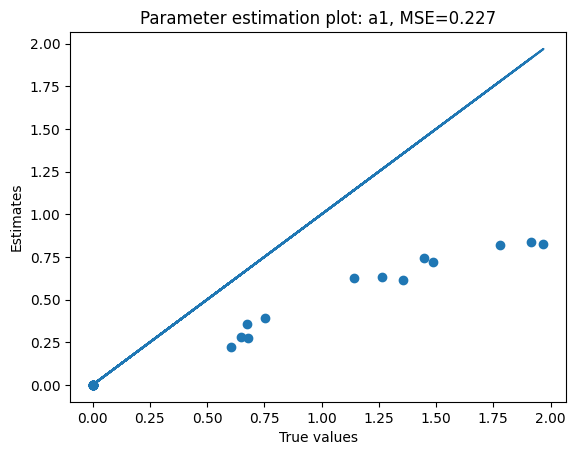

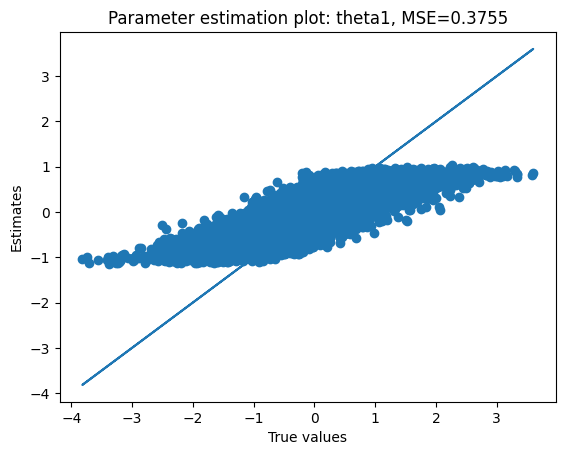

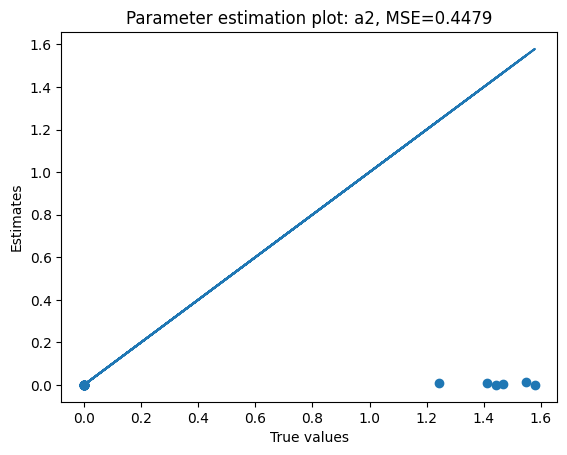

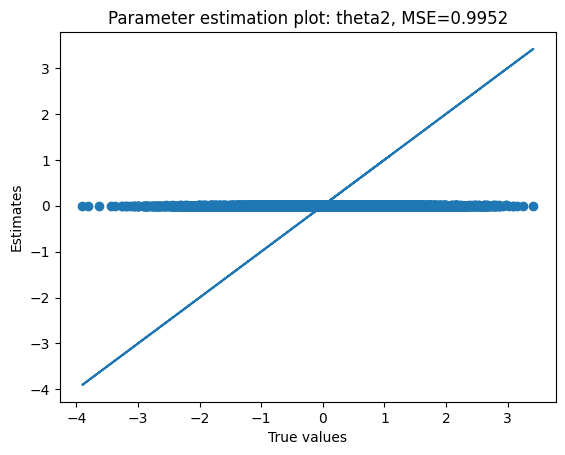

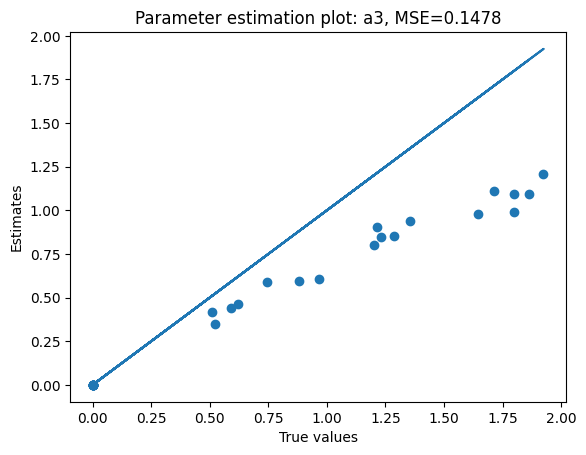

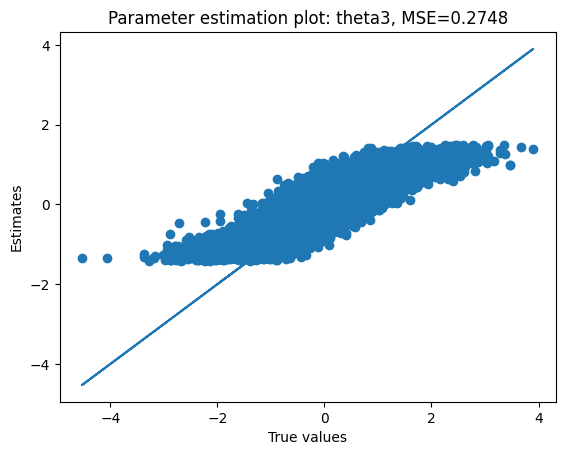

In [124]:
# invert factors for increased interpretability
a_est, theta_est = inv_factors(a_est=a_est, theta_est=theta_est, a_true=a)

# parameter estimation plot for a
for dim in range(cfg['mirt_dim']):
    plt.figure()

    ai_est = a_est[:,dim]
    ai_true = a[:,dim]

    mse = MSE(ai_est, ai_true)
    plt.scatter(y=ai_est, x=ai_true)
    plt.plot(ai_true, ai_true)
    #for i, x in enumerate(ai_true):
    #    plt.text(ai_true[i], ai_est[i], i)
    plt.title(f'Parameter estimation plot: a{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')
    plt.savefig(f'./figures/simfit/param_est_plot_a{dim+1}.png')

    # parameter estimation plot for theta
    plt.figure()
    thetai_est = theta_est[:, dim]
    thetai_true = theta[:, dim]
    mse = MSE(thetai_est, thetai_true)
    plt.scatter(y=thetai_est, x=thetai_true)
    plt.plot(thetai_true, thetai_true)
    plt.title(f'Parameter estimation plot: theta{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')
    plt.savefig(f'./figures/simfit/param_est_plot_theta{dim+1}.png')

/var/folders/md/8qm8pjlx6yvdf6b3y8ldbf740000gn/T/ipykernel_44575/160600589.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(theta_est[:,2], hist=True, kde=True,


<AxesSubplot: ylabel='Density'>

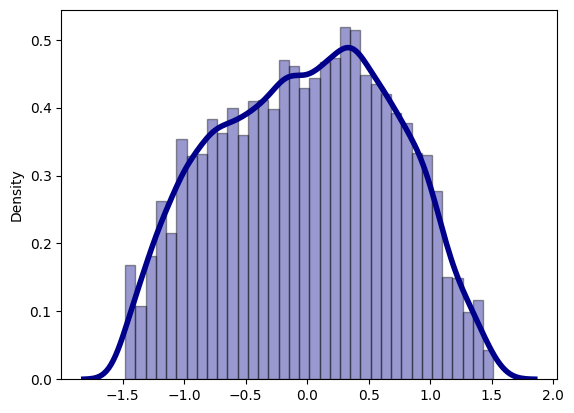

In [113]:
import seaborn as sns
# Density Plot and Histogram of all arrival delays
sns.distplot(theta_est[:,2], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [110]:
theta_est

array([[-7.5553432e-03,  4.3873489e-04, -1.4226625e+00],
       [-2.9714219e-03, -2.7093142e-03,  5.5250257e-01],
       [-5.5979937e-03,  9.5476210e-03,  6.5093738e-01],
       ...,
       [-7.9210661e-03,  1.6246289e-03,  6.1345929e-01],
       [-4.7985166e-03,  1.9840896e-03,  5.5805618e-01],
       [-3.8241819e-03,  4.5608133e-03, -1.5152676e-01]], dtype=float32)